In [1]:
# Import required libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load all results from experiment directories
def load_all_results(base_dir='.'):
    """
    Scan all experiment directories and load results_summary.json files
    """
    results = []
    
    for item in Path(base_dir).iterdir():
        if item.is_dir() and item.name.startswith('bs'):
            results_file = item / 'results_summary.json'
            if results_file.exists():
                try:
                    with open(results_file, 'r') as f:
                        data = json.load(f)
                        results.append(data)
                except Exception as e:
                    print(f"Error loading {results_file}: {e}")
    
    return results

# Load all results
all_results = load_all_results()
print(f"✓ Loaded {len(all_results)} experiment results")

✓ Loaded 24 experiment results


In [3]:
# Convert to DataFrame for easier analysis
def results_to_dataframe(results):
    """
    Convert nested JSON results to flat pandas DataFrame
    """
    rows = []
    
    for result in results:
        exp_name = result['experiment_name']
        params = result['hyperparameters']
        
        # Binary classification results
        for model_name, metrics in result['binary'].items():
            # Extract base model name (MLP or CNN) for balanced comparison
            model_base = 'MLP' if 'MLP' in model_name else 'CNN'
            row = {
                'experiment': exp_name,
                'batch_size': params['batch_size'],
                'local_epochs': params['local_epochs'],
                'learning_rate': params['learning_rate'],
                'alpha': params['alpha'],
                'classification': 'Binary',
                'model': model_name,
                'model_base': model_base,  # NEW: base model name for pivoting
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'auc_roc': metrics['auc_roc']
            }
            rows.append(row)
        
        # Multi-class classification results
        for model_name, metrics in result['multi'].items():
            # Extract base model name (MLP or CNN) for balanced comparison
            model_base = 'MLP' if 'MLP' in model_name else 'CNN'
            row = {
                'experiment': exp_name,
                'batch_size': params['batch_size'],
                'local_epochs': params['local_epochs'],
                'learning_rate': params['learning_rate'],
                'alpha': params['alpha'],
                'classification': 'Multi-class',
                'model': model_name,
                'model_base': model_base,  # NEW: base model name for pivoting
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'auc_roc': metrics['auc_roc']
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

df = results_to_dataframe(all_results)
print(f"✓ Created DataFrame with {len(df)} rows")
print(f"\\nDataFrame shape: {df.shape}")
print(f"\\nColumns: {list(df.columns)}")
df.head()

✓ Created DataFrame with 96 rows
\nDataFrame shape: (96, 13)
\nColumns: ['experiment', 'batch_size', 'local_epochs', 'learning_rate', 'alpha', 'classification', 'model', 'model_base', 'accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']


,experiment,batch_size,local_epochs,learning_rate,alpha,classification,model,model_base,accuracy,precision,recall,f1_score,auc_roc
0,bs1024_epoch2_lr0p0005_alpha5p0,1024,2,0.0005,5.0,Binary,MLP Binary,MLP,0.956952,0.948736,0.997485,0.972500,0.994191
1,bs1024_epoch2_lr0p0005_alpha5p0,1024,2,0.0005,5.0,Binary,CNN Binary,CNN,0.967400,0.990987,0.966065,0.978368,0.996798
2,bs1024_epoch2_lr0p0005_alpha5p0,1024,2,0.0005,5.0,Multi-class,MLP Multi,MLP,0.738302,0.771659,0.738302,0.731156,0.963328
3,bs1024_epoch2_lr0p0005_alpha5p0,1024,2,0.0005,5.0,Multi-class,CNN Multi,CNN,0.740482,0.784175,0.740482,0.704021,0.975849
4,bs1024_epoch2_lr0p0005_alpha0p3,1024,2,0.0005,0.3,Binary,MLP Binary,MLP,0.955626,0.946617,0.998137,0.971695,0.993225


In [4]:
# Summary statistics
print("="*80)
print("EXPERIMENT SUMMARY STATISTICS")
print("="*80)

print(f"\nTotal Experiments: {len(all_results)}")
print(f"Total Model Evaluations: {len(df)}")
print(f"\nUnique Parameters:")
print(f"  - Batch Sizes: {sorted(df['batch_size'].unique())}")
print(f"  - Local Epochs: {sorted(df['local_epochs'].unique())}")
print(f"  - Learning Rates: {sorted(df['learning_rate'].unique())}")
print(f"  - Alphas: {sorted(df['alpha'].unique())}")
print(f"  - Models: {sorted(df['model'].unique())}")

print(f"\n" + "="*80)
print("OVERALL PERFORMANCE STATISTICS")
print("="*80)
print(df.groupby('classification')[['accuracy', 'f1_score', 'auc_roc']].describe())

EXPERIMENT SUMMARY STATISTICS

Total Experiments: 24
Total Model Evaluations: 96

Unique Parameters:
  - Batch Sizes: [np.int64(256), np.int64(512), np.int64(1024)]
  - Local Epochs: [np.int64(1), np.int64(2)]
  - Learning Rates: [np.float64(0.0005), np.float64(0.001)]
  - Alphas: [np.float64(0.3), np.float64(5.0)]
  - Models: ['CNN Binary', 'CNN Multi', 'MLP Binary', 'MLP Multi']

OVERALL PERFORMANCE STATISTICS
               accuracy                                                    \
                  count      mean       std       min       25%       50%   
classification                                                              
Binary             48.0  0.953783  0.018886  0.864436  0.955596  0.956846   
Multi-class        48.0  0.688169  0.092305  0.402544  0.666623  0.710725   

                                   f1_score            ...            \
                     75%       max    count      mean  ...       75%   
classification                                        

## 1. Alpha (Dirichlet) Impact Analysis

Analyze how different alpha values (data heterogeneity levels) affect model performance.

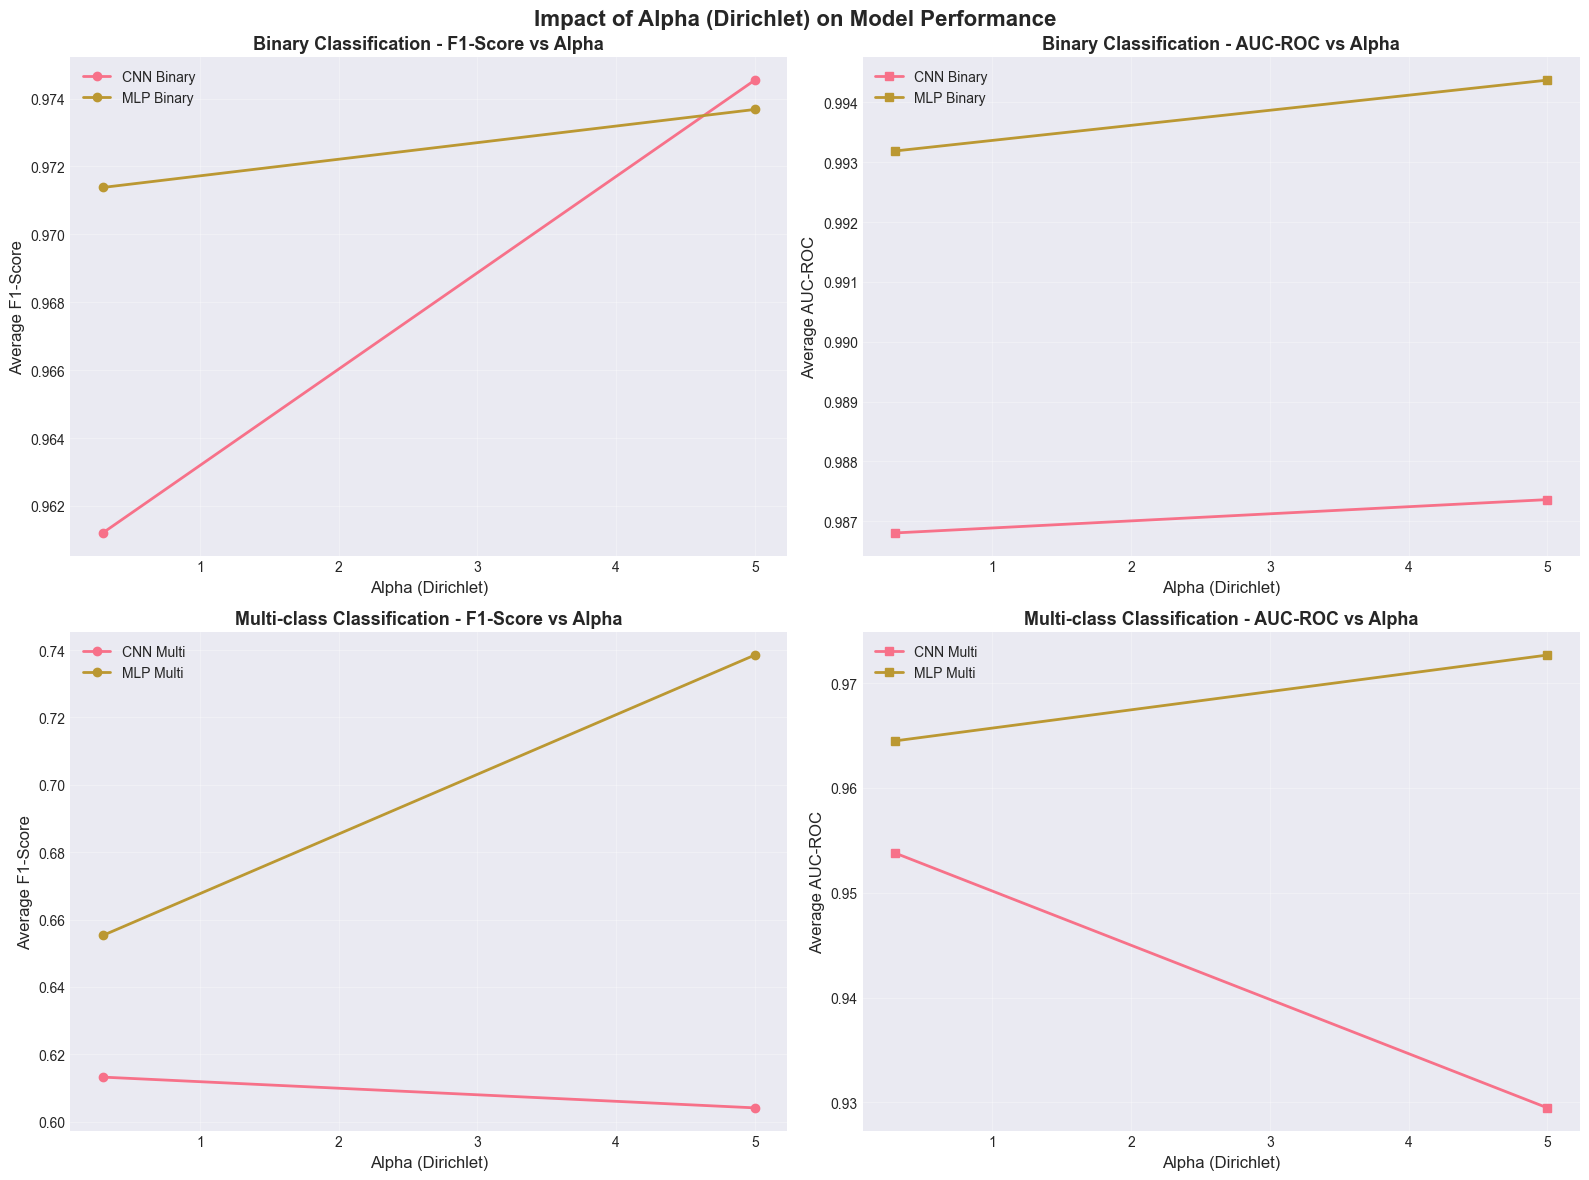


✓ Alpha impact analysis plot saved as 'alpha_impact_analysis.png'


In [5]:
# Alpha impact on F1-Score and AUC-ROC
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Impact of Alpha (Dirichlet) on Model Performance', fontsize=16, fontweight='bold')

# Binary - F1 Score
binary_df = df[df['classification'] == 'Binary']
alpha_f1_binary = binary_df.groupby(['alpha', 'model'])['f1_score'].mean().reset_index()
for model in alpha_f1_binary['model'].unique():
    model_data = alpha_f1_binary[alpha_f1_binary['model'] == model]
    axes[0, 0].plot(model_data['alpha'], model_data['f1_score'], marker='o', label=model, linewidth=2)
axes[0, 0].set_xlabel('Alpha (Dirichlet)', fontsize=12)
axes[0, 0].set_ylabel('Average F1-Score', fontsize=12)
axes[0, 0].set_title('Binary Classification - F1-Score vs Alpha', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Binary - AUC-ROC
alpha_auc_binary = binary_df.groupby(['alpha', 'model'])['auc_roc'].mean().reset_index()
for model in alpha_auc_binary['model'].unique():
    model_data = alpha_auc_binary[alpha_auc_binary['model'] == model]
    axes[0, 1].plot(model_data['alpha'], model_data['auc_roc'], marker='s', label=model, linewidth=2)
axes[0, 1].set_xlabel('Alpha (Dirichlet)', fontsize=12)
axes[0, 1].set_ylabel('Average AUC-ROC', fontsize=12)
axes[0, 1].set_title('Binary Classification - AUC-ROC vs Alpha', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Multi-class - F1 Score
multi_df = df[df['classification'] == 'Multi-class']
alpha_f1_multi = multi_df.groupby(['alpha', 'model'])['f1_score'].mean().reset_index()
for model in alpha_f1_multi['model'].unique():
    model_data = alpha_f1_multi[alpha_f1_multi['model'] == model]
    axes[1, 0].plot(model_data['alpha'], model_data['f1_score'], marker='o', label=model, linewidth=2)
axes[1, 0].set_xlabel('Alpha (Dirichlet)', fontsize=12)
axes[1, 0].set_ylabel('Average F1-Score', fontsize=12)
axes[1, 0].set_title('Multi-class Classification - F1-Score vs Alpha', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Multi-class - AUC-ROC
alpha_auc_multi = multi_df.groupby(['alpha', 'model'])['auc_roc'].mean().reset_index()
for model in alpha_auc_multi['model'].unique():
    model_data = alpha_auc_multi[alpha_auc_multi['model'] == model]
    axes[1, 1].plot(model_data['alpha'], model_data['auc_roc'], marker='s', label=model, linewidth=2)
axes[1, 1].set_xlabel('Alpha (Dirichlet)', fontsize=12)
axes[1, 1].set_ylabel('Average AUC-ROC', fontsize=12)
axes[1, 1].set_title('Multi-class Classification - AUC-ROC vs Alpha', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('alpha_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Alpha impact analysis plot saved as 'alpha_impact_analysis.png'")

## 2. Batch Size Impact Analysis

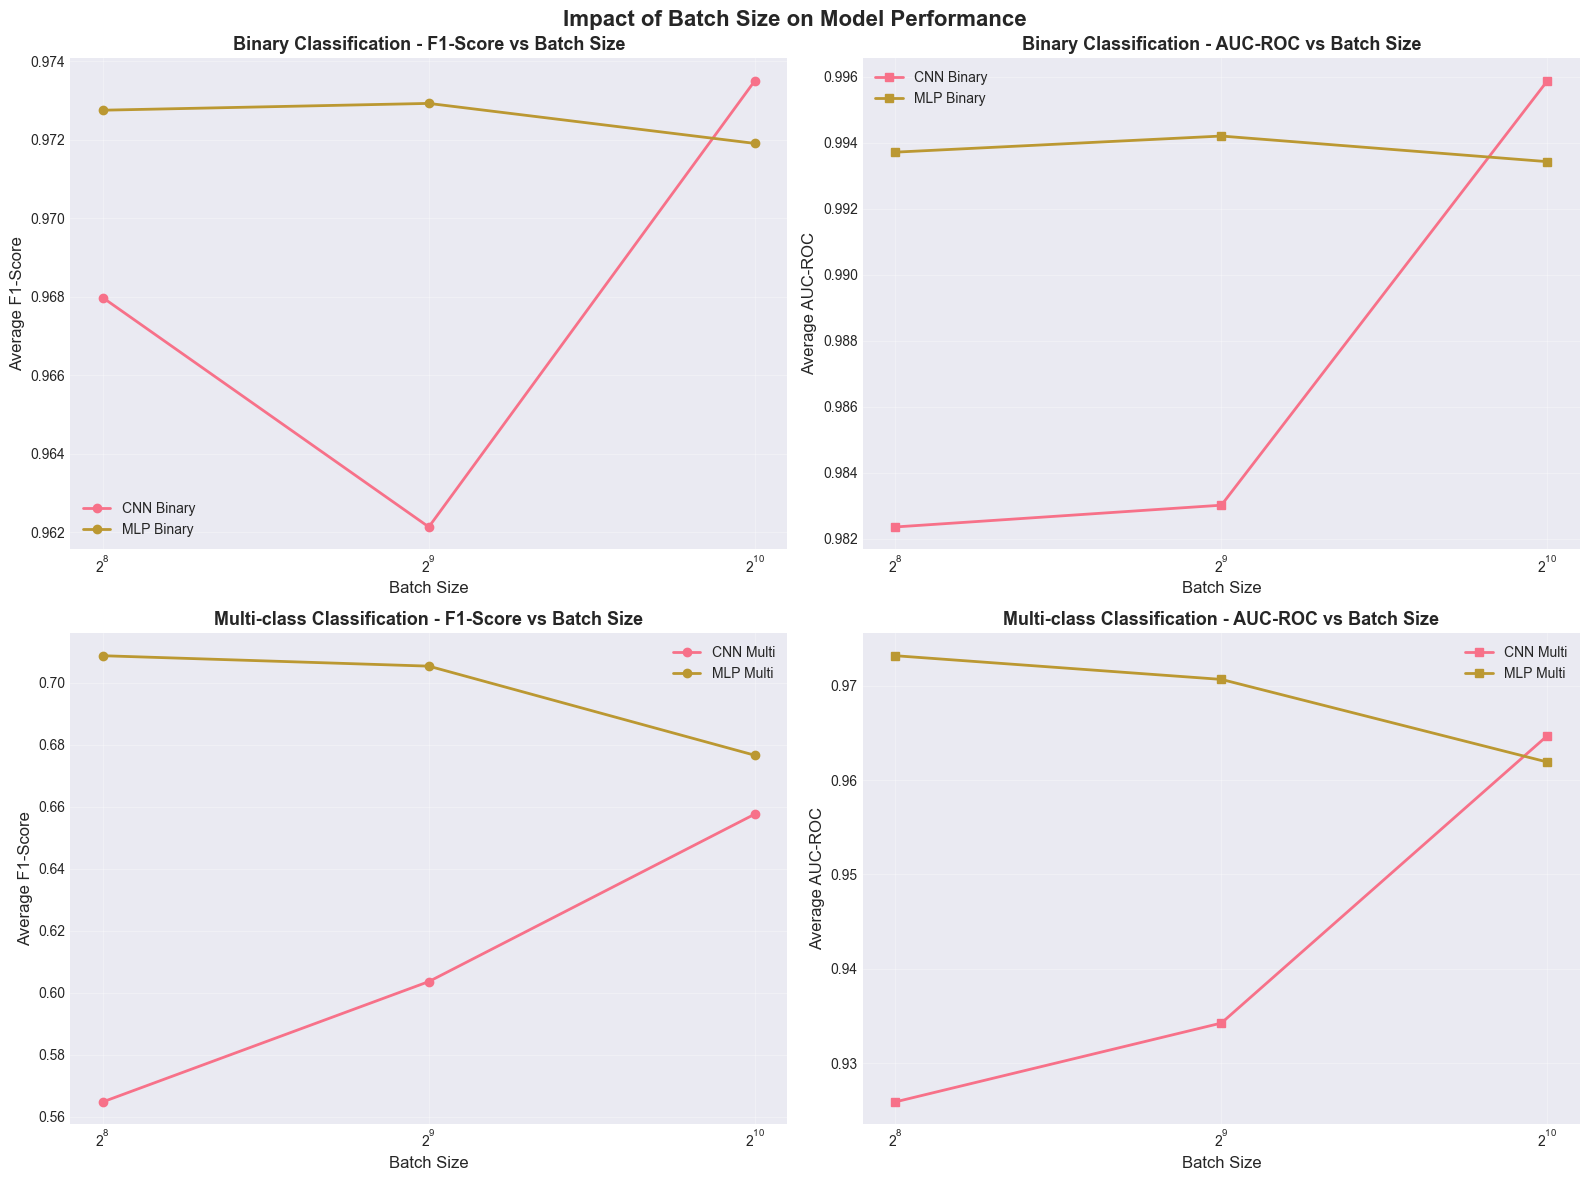


✓ Batch size impact analysis plot saved as 'batch_size_impact_analysis.png'


In [6]:
# Batch size impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Impact of Batch Size on Model Performance', fontsize=16, fontweight='bold')

# Binary - F1 Score
bs_f1_binary = binary_df.groupby(['batch_size', 'model'])['f1_score'].mean().reset_index()
for model in bs_f1_binary['model'].unique():
    model_data = bs_f1_binary[bs_f1_binary['model'] == model]
    axes[0, 0].plot(model_data['batch_size'], model_data['f1_score'], marker='o', label=model, linewidth=2)
axes[0, 0].set_xlabel('Batch Size', fontsize=12)
axes[0, 0].set_ylabel('Average F1-Score', fontsize=12)
axes[0, 0].set_title('Binary Classification - F1-Score vs Batch Size', fontsize=13, fontweight='bold')
axes[0, 0].set_xscale('log', base=2)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Binary - AUC-ROC
bs_auc_binary = binary_df.groupby(['batch_size', 'model'])['auc_roc'].mean().reset_index()
for model in bs_auc_binary['model'].unique():
    model_data = bs_auc_binary[bs_auc_binary['model'] == model]
    axes[0, 1].plot(model_data['batch_size'], model_data['auc_roc'], marker='s', label=model, linewidth=2)
axes[0, 1].set_xlabel('Batch Size', fontsize=12)
axes[0, 1].set_ylabel('Average AUC-ROC', fontsize=12)
axes[0, 1].set_title('Binary Classification - AUC-ROC vs Batch Size', fontsize=13, fontweight='bold')
axes[0, 1].set_xscale('log', base=2)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Multi-class - F1 Score
bs_f1_multi = multi_df.groupby(['batch_size', 'model'])['f1_score'].mean().reset_index()
for model in bs_f1_multi['model'].unique():
    model_data = bs_f1_multi[bs_f1_multi['model'] == model]
    axes[1, 0].plot(model_data['batch_size'], model_data['f1_score'], marker='o', label=model, linewidth=2)
axes[1, 0].set_xlabel('Batch Size', fontsize=12)
axes[1, 0].set_ylabel('Average F1-Score', fontsize=12)
axes[1, 0].set_title('Multi-class Classification - F1-Score vs Batch Size', fontsize=13, fontweight='bold')
axes[1, 0].set_xscale('log', base=2)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Multi-class - AUC-ROC
bs_auc_multi = multi_df.groupby(['batch_size', 'model'])['auc_roc'].mean().reset_index()
for model in bs_auc_multi['model'].unique():
    model_data = bs_auc_multi[bs_auc_multi['model'] == model]
    axes[1, 1].plot(model_data['batch_size'], model_data['auc_roc'], marker='s', label=model, linewidth=2)
axes[1, 1].set_xlabel('Batch Size', fontsize=12)
axes[1, 1].set_ylabel('Average AUC-ROC', fontsize=12)
axes[1, 1].set_title('Multi-class Classification - AUC-ROC vs Batch Size', fontsize=13, fontweight='bold')
axes[1, 1].set_xscale('log', base=2)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('batch_size_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Batch size impact analysis plot saved as 'batch_size_impact_analysis.png'")

## 3. Learning Rate Impact Analysis

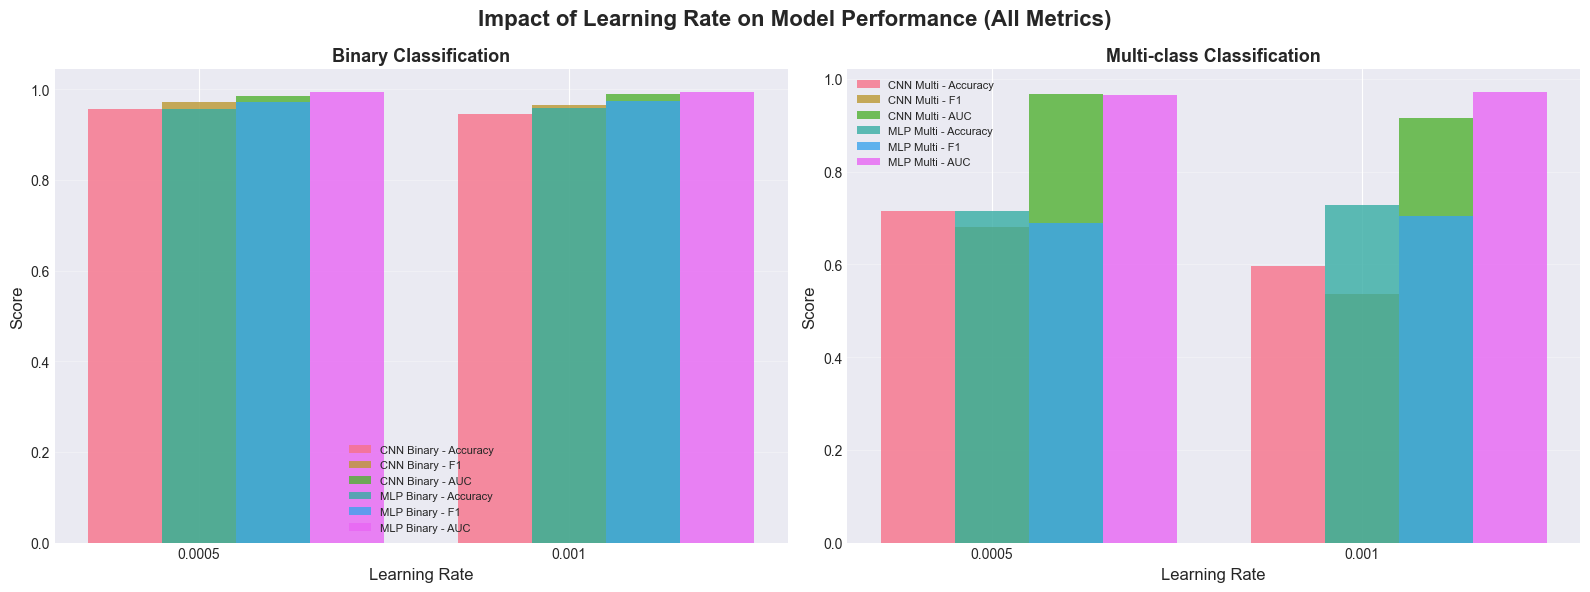


✓ Learning rate impact analysis plot saved as 'learning_rate_impact_analysis.png'


In [7]:
# Learning rate impact
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Impact of Learning Rate on Model Performance (All Metrics)', fontsize=16, fontweight='bold')

# Prepare data
lr_metrics_binary = binary_df.groupby(['learning_rate', 'model']).agg({
    'accuracy': 'mean',
    'f1_score': 'mean',
    'auc_roc': 'mean'
}).reset_index()

lr_metrics_multi = multi_df.groupby(['learning_rate', 'model']).agg({
    'accuracy': 'mean',
    'f1_score': 'mean',
    'auc_roc': 'mean'
}).reset_index()

# Binary classification
x_pos = np.arange(len(lr_metrics_binary['learning_rate'].unique()))
width = 0.2

for i, model in enumerate(lr_metrics_binary['model'].unique()):
    model_data = lr_metrics_binary[lr_metrics_binary['model'] == model]
    axes[0].bar(x_pos + i*width - width, model_data['accuracy'], width, 
               label=f'{model} - Accuracy', alpha=0.8)
    axes[0].bar(x_pos + i*width, model_data['f1_score'], width, 
               label=f'{model} - F1', alpha=0.8)
    axes[0].bar(x_pos + i*width + width, model_data['auc_roc'], width, 
               label=f'{model} - AUC', alpha=0.8)

axes[0].set_xlabel('Learning Rate', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Binary Classification', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(lr_metrics_binary['learning_rate'].unique())
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3, axis='y')

# Multi-class classification
for i, model in enumerate(lr_metrics_multi['model'].unique()):
    model_data = lr_metrics_multi[lr_metrics_multi['model'] == model]
    axes[1].bar(x_pos + i*width - width, model_data['accuracy'], width, 
               label=f'{model} - Accuracy', alpha=0.8)
    axes[1].bar(x_pos + i*width, model_data['f1_score'], width, 
               label=f'{model} - F1', alpha=0.8)
    axes[1].bar(x_pos + i*width + width, model_data['auc_roc'], width, 
               label=f'{model} - AUC', alpha=0.8)

axes[1].set_xlabel('Learning Rate', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Multi-class Classification', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(lr_metrics_multi['learning_rate'].unique())
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('learning_rate_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Learning rate impact analysis plot saved as 'learning_rate_impact_analysis.png'")

## 4. Local Epochs Impact Analysis

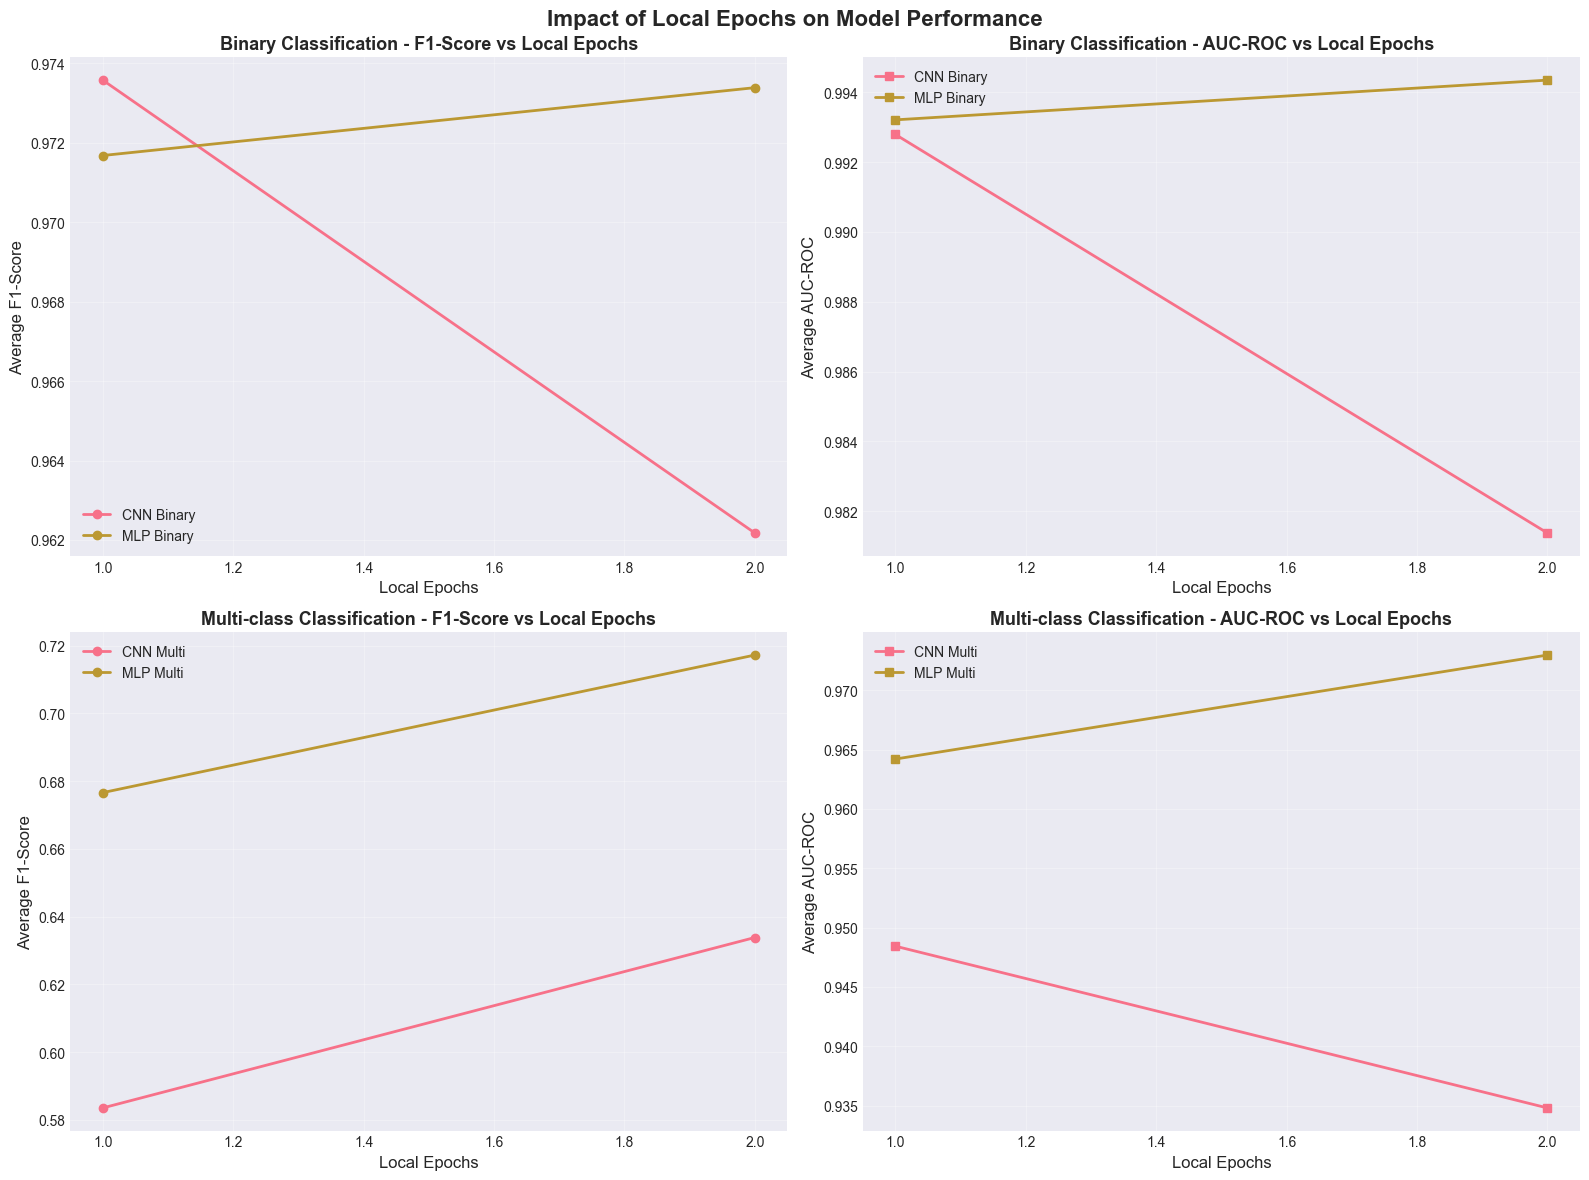


✓ Local epochs impact analysis plot saved as 'local_epochs_impact_analysis.png'


In [8]:
# Local epochs impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Impact of Local Epochs on Model Performance', fontsize=16, fontweight='bold')

# Binary - F1 Score
epochs_f1_binary = binary_df.groupby(['local_epochs', 'model'])['f1_score'].mean().reset_index()
for model in epochs_f1_binary['model'].unique():
    model_data = epochs_f1_binary[epochs_f1_binary['model'] == model]
    axes[0, 0].plot(model_data['local_epochs'], model_data['f1_score'], marker='o', label=model, linewidth=2)
axes[0, 0].set_xlabel('Local Epochs', fontsize=12)
axes[0, 0].set_ylabel('Average F1-Score', fontsize=12)
axes[0, 0].set_title('Binary Classification - F1-Score vs Local Epochs', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Binary - AUC-ROC
epochs_auc_binary = binary_df.groupby(['local_epochs', 'model'])['auc_roc'].mean().reset_index()
for model in epochs_auc_binary['model'].unique():
    model_data = epochs_auc_binary[epochs_auc_binary['model'] == model]
    axes[0, 1].plot(model_data['local_epochs'], model_data['auc_roc'], marker='s', label=model, linewidth=2)
axes[0, 1].set_xlabel('Local Epochs', fontsize=12)
axes[0, 1].set_ylabel('Average AUC-ROC', fontsize=12)
axes[0, 1].set_title('Binary Classification - AUC-ROC vs Local Epochs', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Multi-class - F1 Score
epochs_f1_multi = multi_df.groupby(['local_epochs', 'model'])['f1_score'].mean().reset_index()
for model in epochs_f1_multi['model'].unique():
    model_data = epochs_f1_multi[epochs_f1_multi['model'] == model]
    axes[1, 0].plot(model_data['local_epochs'], model_data['f1_score'], marker='o', label=model, linewidth=2)
axes[1, 0].set_xlabel('Local Epochs', fontsize=12)
axes[1, 0].set_ylabel('Average F1-Score', fontsize=12)
axes[1, 0].set_title('Multi-class Classification - F1-Score vs Local Epochs', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Multi-class - AUC-ROC
epochs_auc_multi = multi_df.groupby(['local_epochs', 'model'])['auc_roc'].mean().reset_index()
for model in epochs_auc_multi['model'].unique():
    model_data = epochs_auc_multi[epochs_auc_multi['model'] == model]
    axes[1, 1].plot(model_data['local_epochs'], model_data['auc_roc'], marker='s', label=model, linewidth=2)
axes[1, 1].set_xlabel('Local Epochs', fontsize=12)
axes[1, 1].set_ylabel('Average AUC-ROC', fontsize=12)
axes[1, 1].set_title('Multi-class Classification - AUC-ROC vs Local Epochs', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('local_epochs_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Local epochs impact analysis plot saved as 'local_epochs_impact_analysis.png'")

## 5. Best Configurations Analysis

In [9]:
# Find top 10 configurations for each metric
print("="*80)
print("TOP 10 CONFIGURATIONS BY METRIC")
print("="*80)

metrics = ['accuracy', 'f1_score', 'auc_roc']

for classification_type in ['Binary', 'Multi-class']:
    print(f"\n{'='*80}")
    print(f"{classification_type.upper()} CLASSIFICATION")
    print(f"{'='*80}")
    
    subset = df[df['classification'] == classification_type]
    
    for metric in metrics:
        print(f"\n{'-'*80}")
        print(f"Top 10 by {metric.upper()}")
        print(f"{'-'*80}")
        
        top_10 = subset.nlargest(10, metric)[[
            'model', 'batch_size', 'local_epochs', 'learning_rate', 'alpha', metric
        ]]
        
        print(top_10.to_string(index=False))

TOP 10 CONFIGURATIONS BY METRIC

BINARY CLASSIFICATION

--------------------------------------------------------------------------------
Top 10 by ACCURACY
--------------------------------------------------------------------------------
     model  batch_size  local_epochs  learning_rate  alpha  accuracy
CNN Binary         256             2         0.0010    5.0  0.968751
CNN Binary         256             1         0.0010    5.0  0.967614
CNN Binary        1024             2         0.0005    5.0  0.967400
CNN Binary        1024             2         0.0010    5.0  0.966903
CNN Binary         512             1         0.0005    5.0  0.966713
MLP Binary         256             2         0.0010    5.0  0.966216
MLP Binary         512             2         0.0010    5.0  0.966145
CNN Binary         512             2         0.0005    5.0  0.966050
MLP Binary         256             2         0.0005    5.0  0.965837
CNN Binary         512             1         0.0010    5.0  0.965671

---

## 6. Heatmap: Parameter Combinations

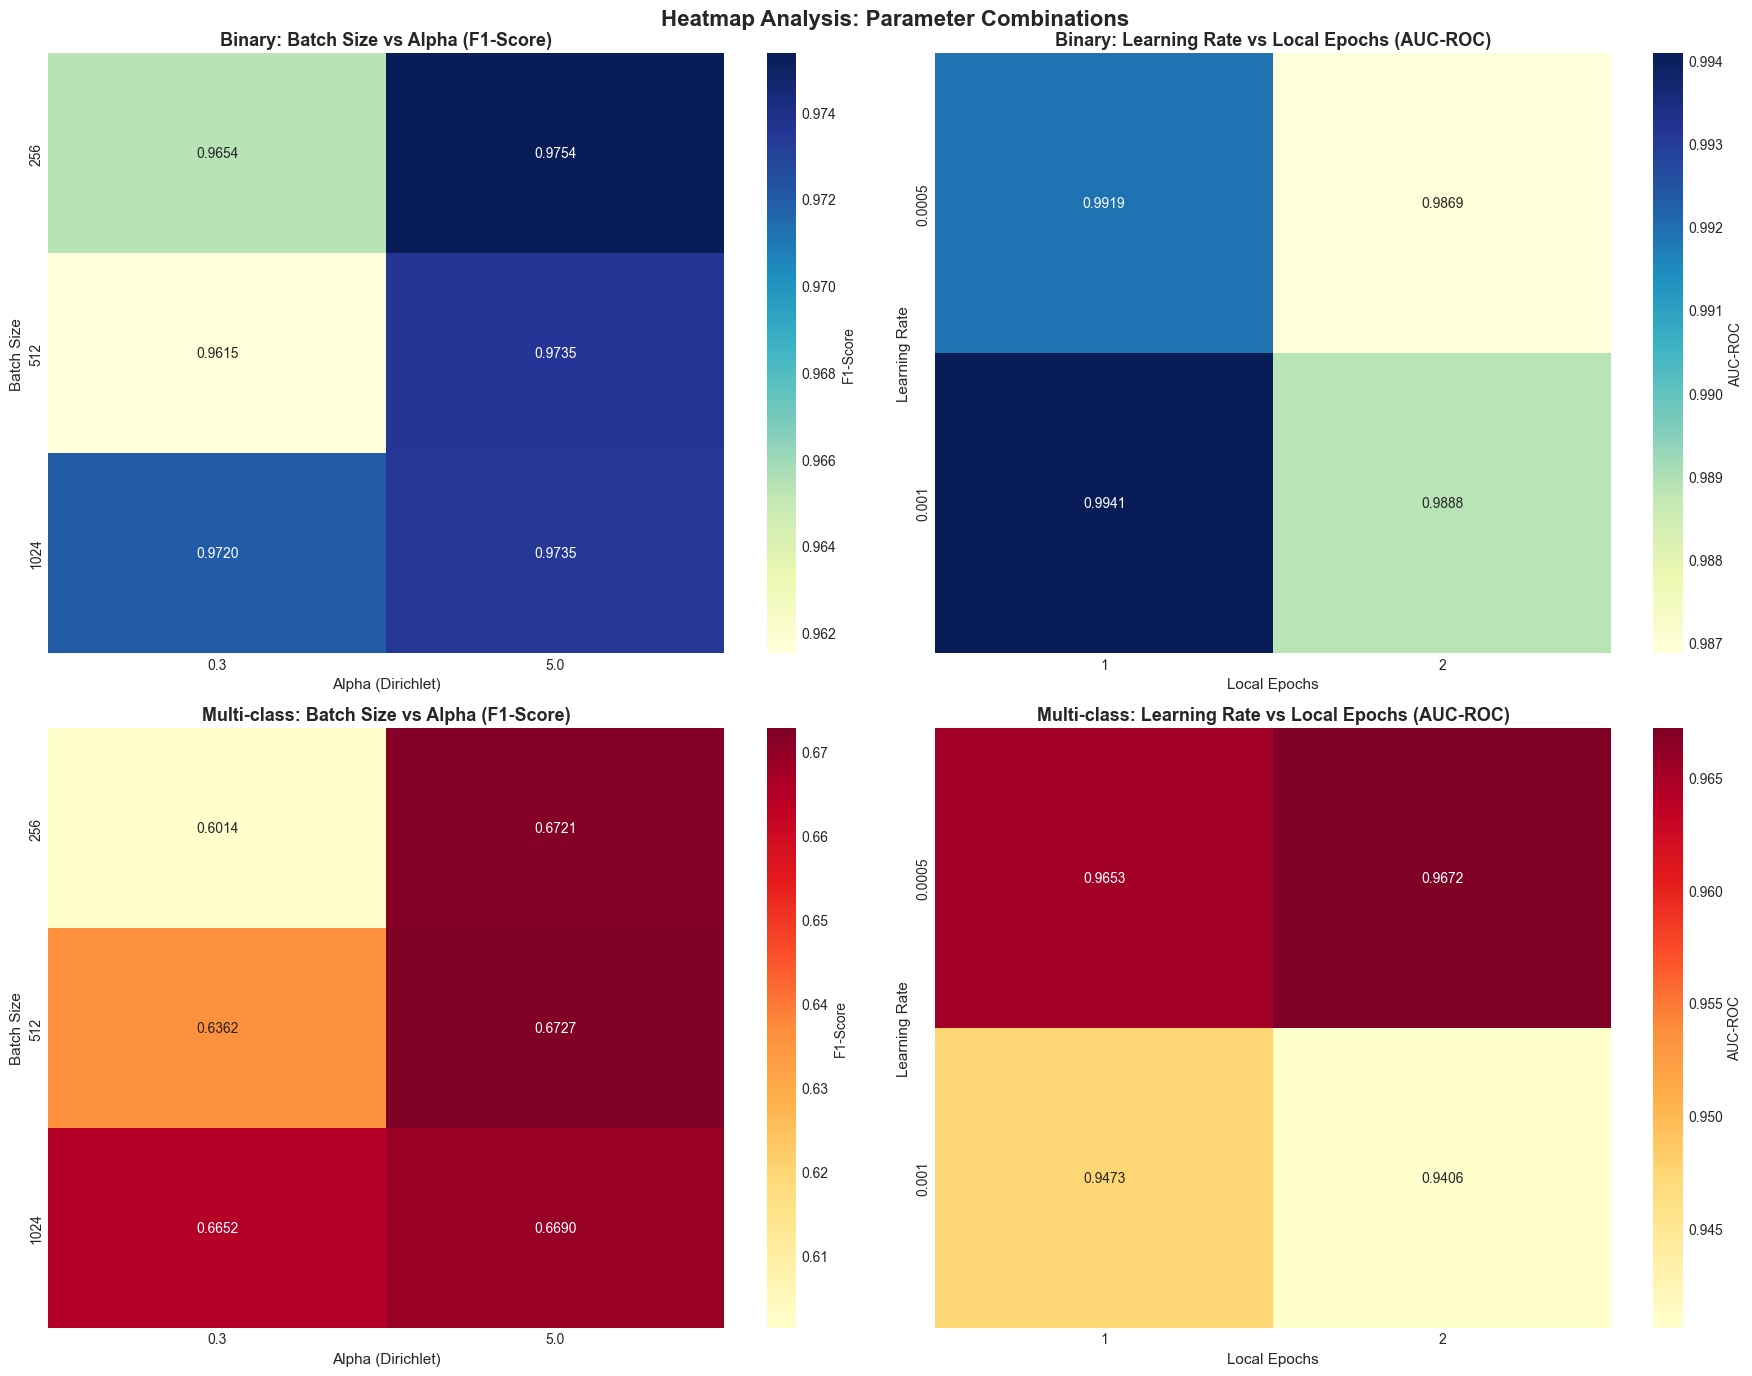


✓ Heatmap analysis plot saved as 'heatmap_parameter_combinations.png'


In [10]:
# Create heatmaps for different parameter combinations
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Heatmap Analysis: Parameter Combinations', fontsize=16, fontweight='bold')

# Binary - Batch Size vs Alpha (F1-Score)
pivot_binary_bs_alpha = binary_df.groupby(['batch_size', 'alpha'])['f1_score'].mean().reset_index()
pivot_binary_bs_alpha = pivot_binary_bs_alpha.pivot(index='batch_size', columns='alpha', values='f1_score')
sns.heatmap(pivot_binary_bs_alpha, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[0, 0], cbar_kws={'label': 'F1-Score'})
axes[0, 0].set_title('Binary: Batch Size vs Alpha (F1-Score)', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Alpha (Dirichlet)', fontsize=11)
axes[0, 0].set_ylabel('Batch Size', fontsize=11)

# Binary - Learning Rate vs Epochs (AUC-ROC)
pivot_binary_lr_epochs = binary_df.groupby(['learning_rate', 'local_epochs'])['auc_roc'].mean().reset_index()
pivot_binary_lr_epochs = pivot_binary_lr_epochs.pivot(index='learning_rate', columns='local_epochs', values='auc_roc')
sns.heatmap(pivot_binary_lr_epochs, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[0, 1], cbar_kws={'label': 'AUC-ROC'})
axes[0, 1].set_title('Binary: Learning Rate vs Local Epochs (AUC-ROC)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Local Epochs', fontsize=11)
axes[0, 1].set_ylabel('Learning Rate', fontsize=11)

# Multi-class - Batch Size vs Alpha (F1-Score)
pivot_multi_bs_alpha = multi_df.groupby(['batch_size', 'alpha'])['f1_score'].mean().reset_index()
pivot_multi_bs_alpha = pivot_multi_bs_alpha.pivot(index='batch_size', columns='alpha', values='f1_score')
sns.heatmap(pivot_multi_bs_alpha, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'F1-Score'})
axes[1, 0].set_title('Multi-class: Batch Size vs Alpha (F1-Score)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Alpha (Dirichlet)', fontsize=11)
axes[1, 0].set_ylabel('Batch Size', fontsize=11)

# Multi-class - Learning Rate vs Epochs (AUC-ROC)
pivot_multi_lr_epochs = multi_df.groupby(['learning_rate', 'local_epochs'])['auc_roc'].mean().reset_index()
pivot_multi_lr_epochs = pivot_multi_lr_epochs.pivot(index='learning_rate', columns='local_epochs', values='auc_roc')
sns.heatmap(pivot_multi_lr_epochs, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'AUC-ROC'})
axes[1, 1].set_title('Multi-class: Learning Rate vs Local Epochs (AUC-ROC)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Local Epochs', fontsize=11)
axes[1, 1].set_ylabel('Learning Rate', fontsize=11)

plt.tight_layout()
plt.savefig('heatmap_parameter_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Heatmap analysis plot saved as 'heatmap_parameter_combinations.png'")

## 7. Model Comparison: MLP vs CNN

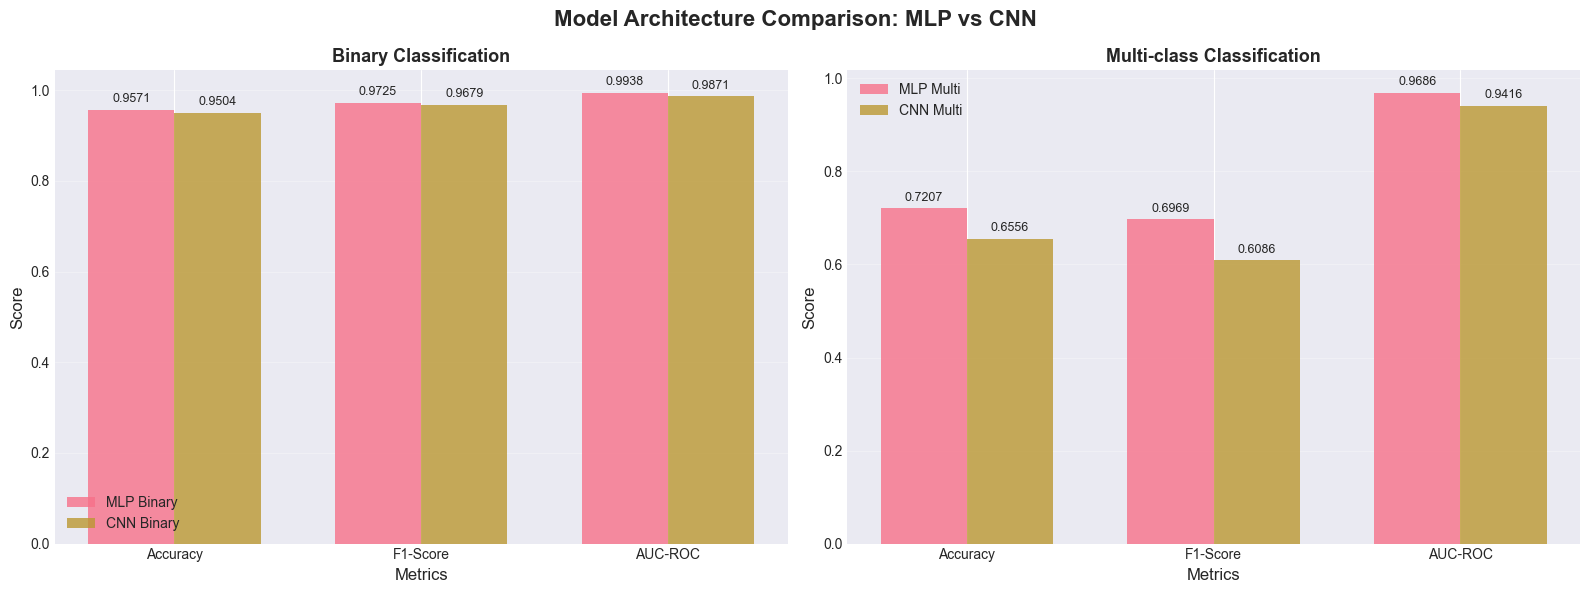


✓ Model comparison plot saved as 'model_architecture_comparison.png'


In [11]:
# Compare MLP vs CNN performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Architecture Comparison: MLP vs CNN', fontsize=16, fontweight='bold')

# Binary classification comparison
mlp_binary = binary_df[binary_df['model'] == 'MLP Binary'][['accuracy', 'f1_score', 'auc_roc']].mean()
cnn_binary = binary_df[binary_df['model'] == 'CNN Binary'][['accuracy', 'f1_score', 'auc_roc']].mean()

x = np.arange(len(mlp_binary))
width = 0.35

axes[0].bar(x - width/2, mlp_binary, width, label='MLP Binary', alpha=0.8)
axes[0].bar(x + width/2, cnn_binary, width, label='CNN Binary', alpha=0.8)
axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Binary Classification', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Accuracy', 'F1-Score', 'AUC-ROC'])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (mlp_val, cnn_val) in enumerate(zip(mlp_binary, cnn_binary)):
    axes[0].text(i - width/2, mlp_val + 0.01, f'{mlp_val:.4f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, cnn_val + 0.01, f'{cnn_val:.4f}', ha='center', va='bottom', fontsize=9)

# Multi-class classification comparison
mlp_multi = multi_df[multi_df['model'] == 'MLP Multi'][['accuracy', 'f1_score', 'auc_roc']].mean()
cnn_multi = multi_df[multi_df['model'] == 'CNN Multi'][['accuracy', 'f1_score', 'auc_roc']].mean()

axes[1].bar(x - width/2, mlp_multi, width, label='MLP Multi', alpha=0.8)
axes[1].bar(x + width/2, cnn_multi, width, label='CNN Multi', alpha=0.8)
axes[1].set_xlabel('Metrics', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Multi-class Classification', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Accuracy', 'F1-Score', 'AUC-ROC'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (mlp_val, cnn_val) in enumerate(zip(mlp_multi, cnn_multi)):
    axes[1].text(i - width/2, mlp_val + 0.01, f'{mlp_val:.4f}', ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, cnn_val + 0.01, f'{cnn_val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_architecture_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Model comparison plot saved as 'model_architecture_comparison.png'")

## 8. Export Summary Statistics

In [12]:
# Export comprehensive statistics to CSV
summary_stats = df.groupby(['classification', 'model']).agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'f1_score': ['mean', 'std', 'min', 'max'],
    'auc_roc': ['mean', 'std', 'min', 'max']
}).round(4)

summary_stats.to_csv('comprehensive_statistics.csv')
print("✓ Comprehensive statistics exported to 'comprehensive_statistics.csv'")

# Export full results
df.to_csv('all_experiment_results.csv', index=False)
print("✓ All experiment results exported to 'all_experiment_results.csv'")

print("\n" + "="*80)
print("Summary Statistics:")
print("="*80)
print(summary_stats)

✓ Comprehensive statistics exported to 'comprehensive_statistics.csv'
✓ All experiment results exported to 'all_experiment_results.csv'

Summary Statistics:
                          accuracy                         f1_score          \
                              mean     std     min     max     mean     std   
classification model                                                          
Binary         CNN Binary   0.9504  0.0263  0.8644  0.9688   0.9679  0.0167   
               MLP Binary   0.9571  0.0038  0.9500  0.9662   0.9725  0.0021   
Multi-class    CNN Multi    0.6556  0.1164  0.4025  0.8005   0.6086  0.1451   
               MLP Multi    0.7207  0.0406  0.6635  0.7905   0.6969  0.0538   

                                          auc_roc                          
                              min     max    mean     std     min     max  
classification model                                                       
Binary         CNN Binary  0.9180  0.9792  0.9871  0.0215  0.

## 9. Final Recommendations

In [13]:
# Generate recommendations based on analysis
print("="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

# Best overall configuration for binary classification
best_binary = df[df['classification'] == 'Binary'].nlargest(1, 'auc_roc').iloc[0]
print("\n1. BEST CONFIGURATION FOR BINARY CLASSIFICATION:")
print(f"   Model: {best_binary['model']}")
print(f"   Batch Size: {best_binary['batch_size']}")
print(f"   Local Epochs: {best_binary['local_epochs']}")
print(f"   Learning Rate: {best_binary['learning_rate']}")
print(f"   Alpha: {best_binary['alpha']}")
print(f"   AUC-ROC: {best_binary['auc_roc']:.4f}")
print(f"   F1-Score: {best_binary['f1_score']:.4f}")
print(f"   Accuracy: {best_binary['accuracy']:.4f}")

# Best overall configuration for multi-class classification
best_multi = df[df['classification'] == 'Multi-class'].nlargest(1, 'auc_roc').iloc[0]
print("\n2. BEST CONFIGURATION FOR MULTI-CLASS CLASSIFICATION:")
print(f"   Model: {best_multi['model']}")
print(f"   Batch Size: {best_multi['batch_size']}")
print(f"   Local Epochs: {best_multi['local_epochs']}")
print(f"   Learning Rate: {best_multi['learning_rate']}")
print(f"   Alpha: {best_multi['alpha']}")
print(f"   AUC-ROC: {best_multi['auc_roc']:.4f}")
print(f"   F1-Score: {best_multi['f1_score']:.4f}")
print(f"   Accuracy: {best_multi['accuracy']:.4f}")

# Key insights
print("\n3. KEY INSIGHTS:")
print("\n   a) Alpha (Data Heterogeneity):")
avg_by_alpha = df.groupby('alpha')['auc_roc'].mean().sort_values(ascending=False)
print(f"      - Best Alpha: {avg_by_alpha.index[0]} (Avg AUC-ROC: {avg_by_alpha.iloc[0]:.4f})")
print(f"      - Lower alpha (0.3-0.5) = More heterogeneous (Non-IID)")
print(f"      - Higher alpha (5.0) = More homogeneous (IID-like)")

print("\n   b) Batch Size:")
avg_by_bs = df.groupby('batch_size')['auc_roc'].mean().sort_values(ascending=False)
print(f"      - Best Batch Size: {avg_by_bs.index[0]} (Avg AUC-ROC: {avg_by_bs.iloc[0]:.4f})")

print("\n   c) Learning Rate:")
avg_by_lr = df.groupby('learning_rate')['auc_roc'].mean().sort_values(ascending=False)
print(f"      - Best Learning Rate: {avg_by_lr.index[0]} (Avg AUC-ROC: {avg_by_lr.iloc[0]:.4f})")

print("\n   d) Local Epochs:")
avg_by_epochs = df.groupby('local_epochs')['auc_roc'].mean().sort_values(ascending=False)
print(f"      - Best Local Epochs: {avg_by_epochs.index[0]} (Avg AUC-ROC: {avg_by_epochs.iloc[0]:.4f})")

print("\n   e) Model Architecture:")
print(f"      - MLP Binary Avg AUC: {df[df['model']=='MLP Binary']['auc_roc'].mean():.4f}")
print(f"      - CNN Binary Avg AUC: {df[df['model']=='CNN Binary']['auc_roc'].mean():.4f}")
print(f"      - MLP Multi Avg AUC: {df[df['model']=='MLP Multi']['auc_roc'].mean():.4f}")
print(f"      - CNN Multi Avg AUC: {df[df['model']=='CNN Multi']['auc_roc'].mean():.4f}")

print("\n" + "="*80)
print("Analysis Complete! All visualizations and statistics have been generated.")
print("="*80)

FINAL RECOMMENDATIONS

1. BEST CONFIGURATION FOR BINARY CLASSIFICATION:
   Model: CNN Binary
   Batch Size: 256
   Local Epochs: 2
   Learning Rate: 0.0005
   Alpha: 0.3
   AUC-ROC: 0.9975
   F1-Score: 0.9728
   Accuracy: 0.9574

2. BEST CONFIGURATION FOR MULTI-CLASS CLASSIFICATION:
   Model: CNN Multi
   Batch Size: 512
   Local Epochs: 2
   Learning Rate: 0.0005
   Alpha: 0.3
   AUC-ROC: 0.9840
   F1-Score: 0.6668
   Accuracy: 0.7146

3. KEY INSIGHTS:

   a) Alpha (Data Heterogeneity):
      - Best Alpha: 0.3 (Avg AUC-ROC: 0.9746)
      - Lower alpha (0.3-0.5) = More heterogeneous (Non-IID)
      - Higher alpha (5.0) = More homogeneous (IID-like)

   b) Batch Size:
      - Best Batch Size: 1024 (Avg AUC-ROC: 0.9790)

   c) Learning Rate:
      - Best Learning Rate: 0.0005 (Avg AUC-ROC: 0.9778)

   d) Local Epochs:
      - Best Local Epochs: 1 (Avg AUC-ROC: 0.9747)

   e) Model Architecture:
      - MLP Binary Avg AUC: 0.9938
      - CNN Binary Avg AUC: 0.9871
      - MLP Multi Avg AU

## 10. Alpha Comparison: 0.3 vs 5.0 (Same Hyperparameters)

Compare performance between alpha=0.3 (more heterogeneous/Non-IID) and alpha=5.0 (more homogeneous/IID-like) for identical hyperparameter configurations.

In [14]:
# Top 10 configurations for Alpha = 0.3
print("="*80)
print("TOP 10 CONFIGURATIONS - ALPHA = 0.3 (More Heterogeneous / Non-IID)")
print("="*80)

df_alpha_03 = df[df['alpha'] == 0.3].copy()

print("\nBINARY CLASSIFICATION (Alpha = 0.3):")
print("-"*80)
top10_binary_03 = df_alpha_03[df_alpha_03['classification'] == 'Binary'].nlargest(10, 'auc_roc')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate', 'accuracy', 'f1_score', 'auc_roc'
]]
print(top10_binary_03.to_string(index=False))

print("\n\nMULTI-CLASS CLASSIFICATION (Alpha = 0.3):")
print("-"*80)
top10_multi_03 = df_alpha_03[df_alpha_03['classification'] == 'Multi-class'].nlargest(10, 'auc_roc')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate', 'accuracy', 'f1_score', 'auc_roc'
]]
print(top10_multi_03.to_string(index=False))

# Top 10 configurations for Alpha = 5.0
print("\n\n" + "="*80)
print("TOP 10 CONFIGURATIONS - ALPHA = 5.0 (More Homogeneous / IID-like)")
print("="*80)

df_alpha_50 = df[df['alpha'] == 5.0].copy()

print("\nBINARY CLASSIFICATION (Alpha = 5.0):")
print("-"*80)
top10_binary_50 = df_alpha_50[df_alpha_50['classification'] == 'Binary'].nlargest(10, 'auc_roc')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate', 'accuracy', 'f1_score', 'auc_roc'
]]
print(top10_binary_50.to_string(index=False))

print("\n\nMULTI-CLASS CLASSIFICATION (Alpha = 5.0):")
print("-"*80)
top10_multi_50 = df_alpha_50[df_alpha_50['classification'] == 'Multi-class'].nlargest(10, 'auc_roc')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate', 'accuracy', 'f1_score', 'auc_roc'
]]
print(top10_multi_50.to_string(index=False))

TOP 10 CONFIGURATIONS - ALPHA = 0.3 (More Heterogeneous / Non-IID)

BINARY CLASSIFICATION (Alpha = 0.3):
--------------------------------------------------------------------------------
     model  batch_size  local_epochs  learning_rate  accuracy  f1_score  auc_roc
CNN Binary         256             2         0.0005  0.957426  0.972806 0.997460
CNN Binary        1024             2         0.0005  0.957971  0.973149 0.997429
CNN Binary        1024             2         0.0010  0.957782  0.973023 0.997106
CNN Binary         256             1         0.0005  0.957189  0.972669 0.996694
CNN Binary        1024             1         0.0005  0.957331  0.972739 0.996016
CNN Binary         512             1         0.0005  0.957118  0.972611 0.995924
CNN Binary         512             1         0.0010  0.956028  0.971907 0.995741
CNN Binary        1024             1         0.0010  0.955318  0.971388 0.994485
MLP Binary         512             2         0.0005  0.956194  0.972036 0.994312
MLP 

In [15]:
# Direct comparison: Alpha 0.3 vs 5.0 with same hyperparameters
print("\n\n" + "="*80)
print("DIRECT COMPARISON: ALPHA 0.3 vs 5.0 (SAME HYPERPARAMETERS)")
print("="*80)
print("Alpha 0.3 = More Heterogeneous (Non-IID)")
print("Alpha 5.0 = More Homogeneous (IID-like)")
print("="*80)

# Create comparison dataframe
df_03 = df[df['alpha'] == 0.3].copy()
df_50 = df[df['alpha'] == 5.0].copy()

# Merge on hyperparameters to compare same configurations
comparison = df_03.merge(
    df_50,
    on=['batch_size', 'local_epochs', 'learning_rate', 'model', 'classification'],
    suffixes=('_alpha03', '_alpha50')
)

# Calculate differences
comparison['acc_diff'] = comparison['accuracy_alpha50'] - comparison['accuracy_alpha03']
comparison['f1_diff'] = comparison['f1_score_alpha50'] - comparison['f1_score_alpha03']
comparison['auc_diff'] = comparison['auc_roc_alpha50'] - comparison['auc_roc_alpha03']

# Sort by AUC difference (descending - where alpha 5.0 performs better)
comparison_sorted = comparison.sort_values('auc_diff', ascending=False)

print("\n" + "-"*80)
print("TOP 10: Where Alpha 5.0 (IID-like) OUTPERFORMS Alpha 0.3 (Non-IID)")
print("-"*80)
top_50_better = comparison_sorted.head(10)[[
    'classification', 'model', 'batch_size', 'local_epochs', 'learning_rate',
    'auc_roc_alpha03', 'auc_roc_alpha50', 'auc_diff'
]]
print(top_50_better.to_string(index=False))

print("\n\n" + "-"*80)
print("TOP 10: Where Alpha 0.3 (Non-IID) OUTPERFORMS Alpha 5.0 (IID-like)")
print("-"*80)
top_03_better = comparison_sorted.tail(10)[[
    'classification', 'model', 'batch_size', 'local_epochs', 'learning_rate',
    'auc_roc_alpha03', 'auc_roc_alpha50', 'auc_diff'
]]
print(top_03_better.to_string(index=False))

# Summary statistics
print("\n\n" + "="*80)
print("SUMMARY STATISTICS: Alpha 0.3 vs 5.0")
print("="*80)

for classification_type in ['Binary', 'Multi-class']:
    subset = comparison[comparison['classification'] == classification_type]
    
    print(f"\n{classification_type.upper()} CLASSIFICATION:")
    print("-"*80)
    print(f"  Average AUC-ROC (Alpha 0.3 - Non-IID): {subset['auc_roc_alpha03'].mean():.4f}")
    print(f"  Average AUC-ROC (Alpha 5.0 - IID-like): {subset['auc_roc_alpha50'].mean():.4f}")
    print(f"  Average Difference: {subset['auc_diff'].mean():.4f}")
    print(f"\n  Average F1-Score (Alpha 0.3): {subset['f1_score_alpha03'].mean():.4f}")
    print(f"  Average F1-Score (Alpha 5.0): {subset['f1_score_alpha50'].mean():.4f}")
    print(f"  Average Difference: {subset['f1_diff'].mean():.4f}")
    print(f"\n  Average Accuracy (Alpha 0.3): {subset['accuracy_alpha03'].mean():.4f}")
    print(f"  Average Accuracy (Alpha 5.0): {subset['accuracy_alpha50'].mean():.4f}")
    print(f"  Average Difference: {subset['acc_diff'].mean():.4f}")
    
    # Count wins
    alpha_50_wins = (subset['auc_diff'] > 0).sum()
    alpha_03_wins = (subset['auc_diff'] < 0).sum()
    ties = (subset['auc_diff'] == 0).sum()
    
    print(f"\n  Win/Loss (by AUC-ROC):")
    print(f"    - Alpha 5.0 (IID-like) better: {alpha_50_wins} times")
    print(f"    - Alpha 0.3 (Non-IID) better: {alpha_03_wins} times")
    print(f"    - Ties: {ties} times")



DIRECT COMPARISON: ALPHA 0.3 vs 5.0 (SAME HYPERPARAMETERS)
Alpha 0.3 = More Heterogeneous (Non-IID)
Alpha 5.0 = More Homogeneous (IID-like)

--------------------------------------------------------------------------------
TOP 10: Where Alpha 5.0 (IID-like) OUTPERFORMS Alpha 0.3 (Non-IID)
--------------------------------------------------------------------------------
classification      model  batch_size  local_epochs  learning_rate  auc_roc_alpha03  auc_roc_alpha50  auc_diff
        Binary CNN Binary         512             2         0.0010         0.923897         0.995314  0.071417
   Multi-class  CNN Multi         256             2         0.0010         0.857267         0.923080  0.065813
        Binary CNN Binary         512             2         0.0005         0.964225         0.996400  0.032175
   Multi-class  MLP Multi         256             2         0.0005         0.963918         0.980784  0.016866
   Multi-class  MLP Multi        1024             2         0.0010       

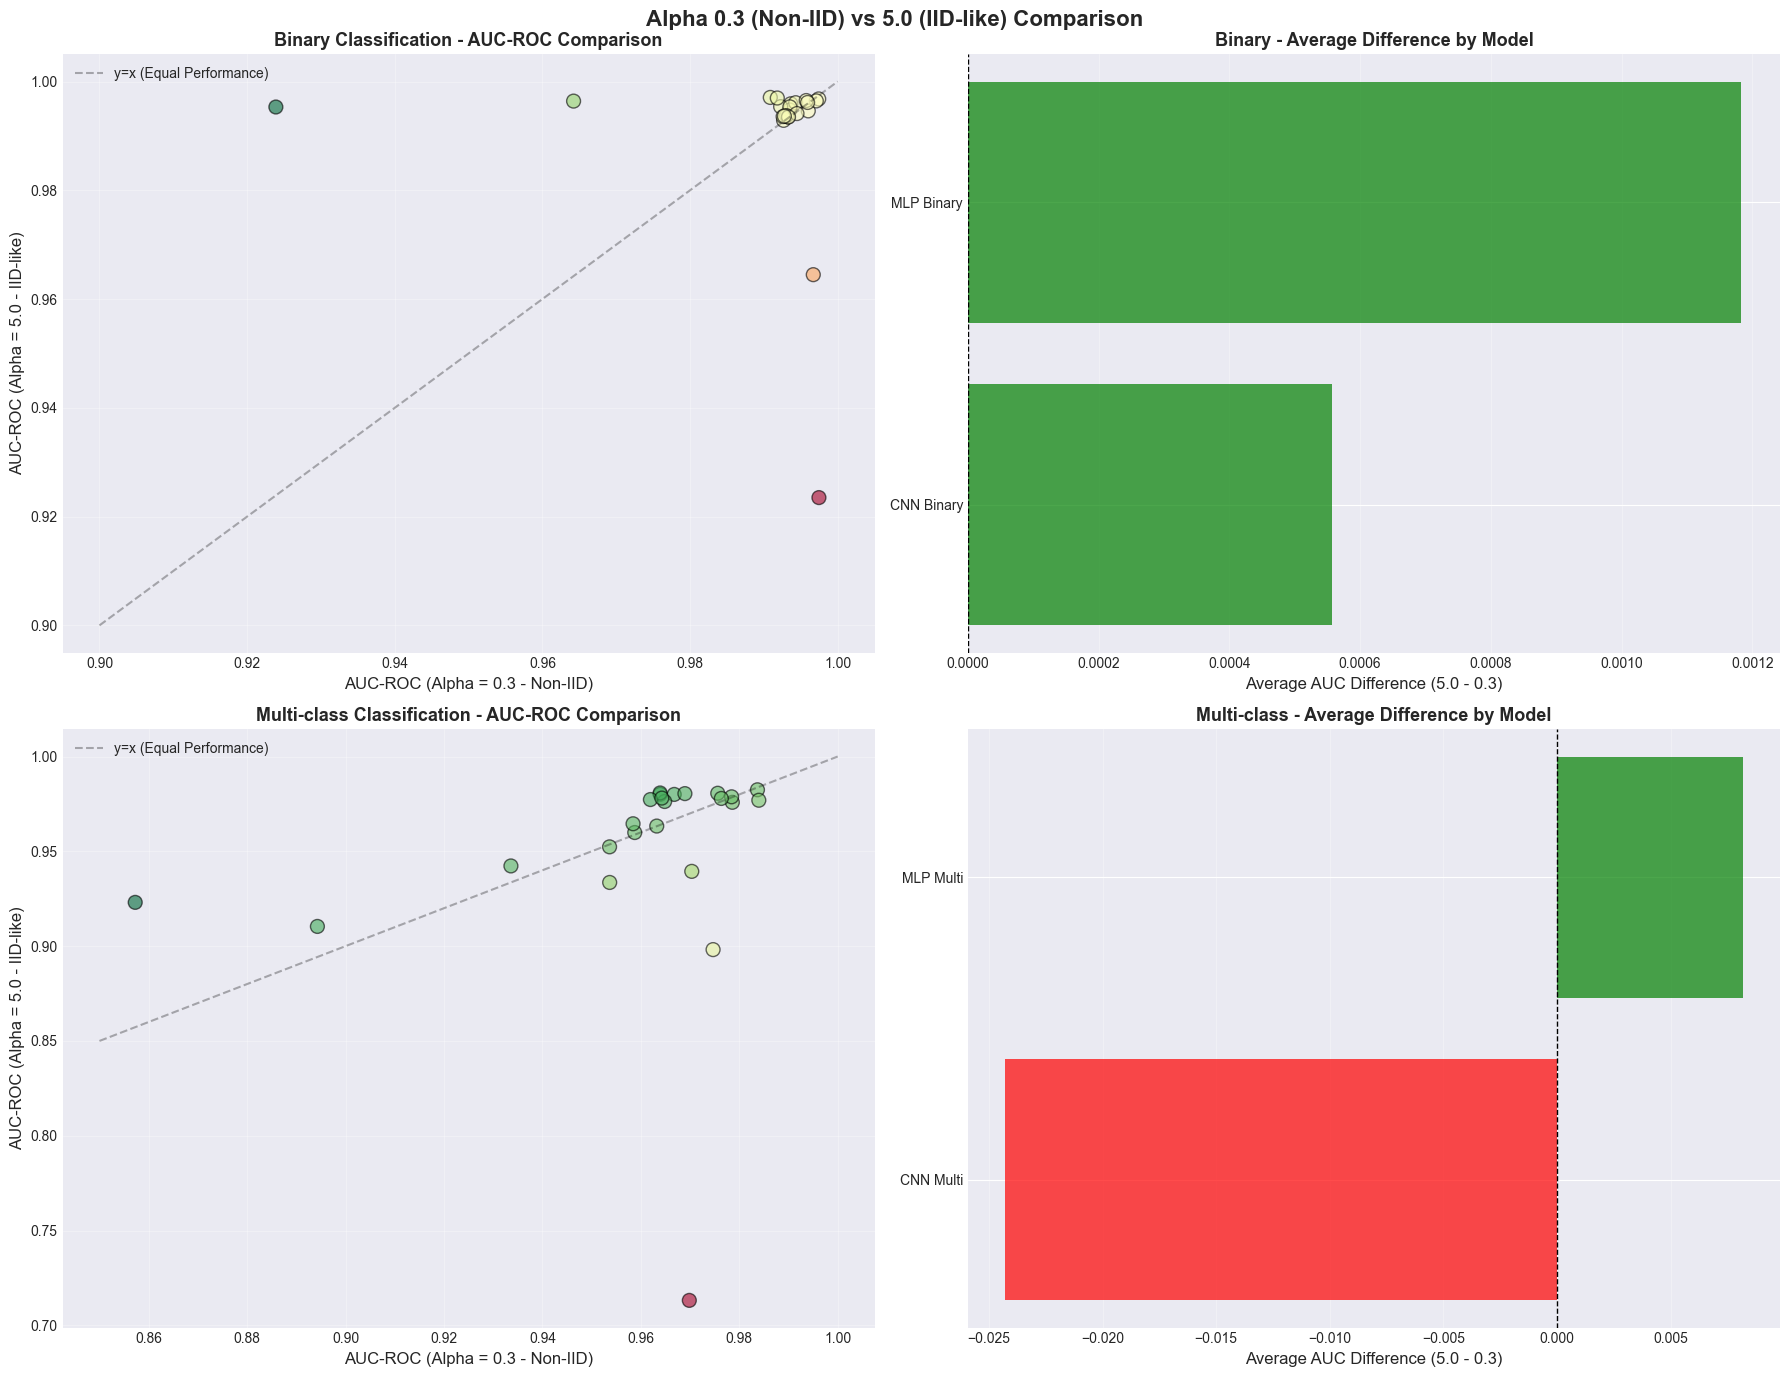


✓ Alpha comparison plot saved as 'alpha_03_vs_50_comparison.png'


In [16]:
# Visualization: Alpha 0.3 vs 5.0 Comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Alpha 0.3 (Non-IID) vs 5.0 (IID-like) Comparison', fontsize=16, fontweight='bold')

# Prepare data for plotting
binary_comp = comparison[comparison['classification'] == 'Binary']
multi_comp = comparison[comparison['classification'] == 'Multi-class']

# Binary - Scatter plot AUC
axes[0, 0].scatter(binary_comp['auc_roc_alpha03'], binary_comp['auc_roc_alpha50'], 
                   alpha=0.6, s=100, c=binary_comp['auc_diff'], cmap='RdYlGn', edgecolors='black')
axes[0, 0].plot([0.9, 1.0], [0.9, 1.0], 'k--', alpha=0.3, label='y=x (Equal Performance)')
axes[0, 0].set_xlabel('AUC-ROC (Alpha = 0.3 - Non-IID)', fontsize=12)
axes[0, 0].set_ylabel('AUC-ROC (Alpha = 5.0 - IID-like)', fontsize=12)
axes[0, 0].set_title('Binary Classification - AUC-ROC Comparison', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Binary - Bar chart of differences
binary_model_diff = binary_comp.groupby('model')['auc_diff'].mean().sort_values()
axes[0, 1].barh(range(len(binary_model_diff)), binary_model_diff.values, 
                color=['red' if x < 0 else 'green' for x in binary_model_diff.values], alpha=0.7)
axes[0, 1].set_yticks(range(len(binary_model_diff)))
axes[0, 1].set_yticklabels(binary_model_diff.index)
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Average AUC Difference (5.0 - 0.3)', fontsize=12)
axes[0, 1].set_title('Binary - Average Difference by Model', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Multi-class - Scatter plot AUC
axes[1, 0].scatter(multi_comp['auc_roc_alpha03'], multi_comp['auc_roc_alpha50'], 
                   alpha=0.6, s=100, c=multi_comp['auc_diff'], cmap='RdYlGn', edgecolors='black')
axes[1, 0].plot([0.85, 1.0], [0.85, 1.0], 'k--', alpha=0.3, label='y=x (Equal Performance)')
axes[1, 0].set_xlabel('AUC-ROC (Alpha = 0.3 - Non-IID)', fontsize=12)
axes[1, 0].set_ylabel('AUC-ROC (Alpha = 5.0 - IID-like)', fontsize=12)
axes[1, 0].set_title('Multi-class Classification - AUC-ROC Comparison', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Multi-class - Bar chart of differences
multi_model_diff = multi_comp.groupby('model')['auc_diff'].mean().sort_values()
axes[1, 1].barh(range(len(multi_model_diff)), multi_model_diff.values, 
                color=['red' if x < 0 else 'green' for x in multi_model_diff.values], alpha=0.7)
axes[1, 1].set_yticks(range(len(multi_model_diff)))
axes[1, 1].set_yticklabels(multi_model_diff.index)
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Average AUC Difference (5.0 - 0.3)', fontsize=12)
axes[1, 1].set_title('Multi-class - Average Difference by Model', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('alpha_03_vs_50_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Alpha comparison plot saved as 'alpha_03_vs_50_comparison.png'")

In [17]:
# Detailed pairwise comparison table
print("\n\n" + "="*80)
print("DETAILED PAIRWISE COMPARISON TABLE")
print("="*80)

# Create detailed comparison for best configurations
print("\nBINARY CLASSIFICATION - Top 5 Pairwise Comparisons:")
print("-"*80)

binary_comparison = comparison[comparison['classification'] == 'Binary'].nlargest(5, 'auc_roc_alpha03')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate',
    'accuracy_alpha03', 'accuracy_alpha50', 'acc_diff',
    'f1_score_alpha03', 'f1_score_alpha50', 'f1_diff',
    'auc_roc_alpha03', 'auc_roc_alpha50', 'auc_diff'
]]

for idx, row in binary_comparison.iterrows():
    print(f"\nConfiguration: BS={row['batch_size']}, Epochs={row['local_epochs']}, LR={row['learning_rate']}, Model={row['model']}")
    print(f"  Accuracy:  α=0.3: {row['accuracy_alpha03']:.4f} | α=5.0: {row['accuracy_alpha50']:.4f} | Diff: {row['acc_diff']:+.4f}")
    print(f"  F1-Score:  α=0.3: {row['f1_score_alpha03']:.4f} | α=5.0: {row['f1_score_alpha50']:.4f} | Diff: {row['f1_diff']:+.4f}")
    print(f"  AUC-ROC:   α=0.3: {row['auc_roc_alpha03']:.4f} | α=5.0: {row['auc_roc_alpha50']:.4f} | Diff: {row['auc_diff']:+.4f}")
    
    # Determine winner
    winner = "Alpha 5.0 (IID-like)" if row['auc_diff'] > 0 else "Alpha 0.3 (Non-IID)" if row['auc_diff'] < 0 else "Tie"
    print(f"  Winner: {winner}")

print("\n\nMULTI-CLASS CLASSIFICATION - Top 5 Pairwise Comparisons:")
print("-"*80)

multi_comparison = comparison[comparison['classification'] == 'Multi-class'].nlargest(5, 'auc_roc_alpha03')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate',
    'accuracy_alpha03', 'accuracy_alpha50', 'acc_diff',
    'f1_score_alpha03', 'f1_score_alpha50', 'f1_diff',
    'auc_roc_alpha03', 'auc_roc_alpha50', 'auc_diff'
]]

for idx, row in multi_comparison.iterrows():
    print(f"\nConfiguration: BS={row['batch_size']}, Epochs={row['local_epochs']}, LR={row['learning_rate']}, Model={row['model']}")
    print(f"  Accuracy:  α=0.3: {row['accuracy_alpha03']:.4f} | α=5.0: {row['accuracy_alpha50']:.4f} | Diff: {row['acc_diff']:+.4f}")
    print(f"  F1-Score:  α=0.3: {row['f1_score_alpha03']:.4f} | α=5.0: {row['f1_score_alpha50']:.4f} | Diff: {row['f1_diff']:+.4f}")
    print(f"  AUC-ROC:   α=0.3: {row['auc_roc_alpha03']:.4f} | α=5.0: {row['auc_roc_alpha50']:.4f} | Diff: {row['auc_diff']:+.4f}")
    
    # Determine winner
    winner = "Alpha 5.0 (IID-like)" if row['auc_diff'] > 0 else "Alpha 0.3 (Non-IID)" if row['auc_diff'] < 0 else "Tie"
    print(f"  Winner: {winner}")

# Export comparison data
comparison.to_csv('alpha_03_vs_50_detailed_comparison.csv', index=False)
print("\n\n✓ Detailed comparison exported to 'alpha_03_vs_50_detailed_comparison.csv'")



DETAILED PAIRWISE COMPARISON TABLE

BINARY CLASSIFICATION - Top 5 Pairwise Comparisons:
--------------------------------------------------------------------------------

Configuration: BS=256, Epochs=2, LR=0.0005, Model=CNN Binary
  Accuracy:  α=0.3: 0.9574 | α=5.0: 0.9558 | Diff: -0.0017
  F1-Score:  α=0.3: 0.9728 | α=5.0: 0.9717 | Diff: -0.0011
  AUC-ROC:   α=0.3: 0.9975 | α=5.0: 0.9235 | Diff: -0.0740
  Winner: Alpha 0.3 (Non-IID)

Configuration: BS=1024, Epochs=2, LR=0.0005, Model=CNN Binary
  Accuracy:  α=0.3: 0.9580 | α=5.0: 0.9674 | Diff: +0.0094
  F1-Score:  α=0.3: 0.9731 | α=5.0: 0.9784 | Diff: +0.0052
  AUC-ROC:   α=0.3: 0.9974 | α=5.0: 0.9968 | Diff: -0.0006
  Winner: Alpha 0.3 (Non-IID)

Configuration: BS=1024, Epochs=2, LR=0.001, Model=CNN Binary
  Accuracy:  α=0.3: 0.9578 | α=5.0: 0.9669 | Diff: +0.0091
  F1-Score:  α=0.3: 0.9730 | α=5.0: 0.9781 | Diff: +0.0050
  AUC-ROC:   α=0.3: 0.9971 | α=5.0: 0.9964 | Diff: -0.0007
  Winner: Alpha 0.3 (Non-IID)

Configuration: BS=25

## 11. Best Hyperparameter Selection (Alpha = 0.3 Only)

Select the single best hyperparameter configuration from alpha=0.3 experiments based on weighted scoring of all metrics (Accuracy, F1-Score, Precision, Recall, AUC-ROC).

In [18]:
# Define weights for each metric (sum should equal 1.0)
# Adjust these weights based on your priorities
METRIC_WEIGHTS = {
    'accuracy': 0.20,
    'precision': 0.20,
    'recall': 0.20,
    'f1_score': 0.20,
    'auc_roc': 0.20
}

print("="*80)
print("BEST HYPERPARAMETER SELECTION - ALPHA = 0.3 (Non-IID)")
print("="*80)
print("\nMetric Weights:")
for metric, weight in METRIC_WEIGHTS.items():
    print(f"  {metric.upper()}: {weight*100:.0f}%")

# Filter only alpha=0.3 experiments
df_alpha_03_only = df[df['alpha'] == 0.3].copy()

# Calculate weighted score for each configuration
df_alpha_03_only['weighted_score'] = (
    df_alpha_03_only['accuracy'] * METRIC_WEIGHTS['accuracy'] +
    df_alpha_03_only['precision'] * METRIC_WEIGHTS['precision'] +
    df_alpha_03_only['recall'] * METRIC_WEIGHTS['recall'] +
    df_alpha_03_only['f1_score'] * METRIC_WEIGHTS['f1_score'] +
    df_alpha_03_only['auc_roc'] * METRIC_WEIGHTS['auc_roc']
)

print("\n" + "="*80)
print("BINARY CLASSIFICATION - BEST CONFIGURATION (Alpha = 0.3)")
print("="*80)

# Get best configuration for Binary
best_binary_03 = df_alpha_03_only[df_alpha_03_only['classification'] == 'Binary'].nlargest(1, 'weighted_score').iloc[0]

print(f"\n🏆 BEST HYPERPARAMETER CONFIGURATION:")
print(f"   Model: {best_binary_03['model']}")
print(f"   Batch Size: {best_binary_03['batch_size']}")
print(f"   Local Epochs: {best_binary_03['local_epochs']}")
print(f"   Learning Rate: {best_binary_03['learning_rate']}")
print(f"   Alpha: {best_binary_03['alpha']}")
print(f"\n   WEIGHTED SCORE: {best_binary_03['weighted_score']:.6f}")
print(f"\n   Individual Metrics:")
print(f"   - Accuracy:  {best_binary_03['accuracy']:.6f}")
print(f"   - Precision: {best_binary_03['precision']:.6f}")
print(f"   - Recall:    {best_binary_03['recall']:.6f}")
print(f"   - F1-Score:  {best_binary_03['f1_score']:.6f}")
print(f"   - AUC-ROC:   {best_binary_03['auc_roc']:.6f}")

print("\n" + "-"*80)
print("Top 10 Configurations (Binary):")
print("-"*80)

top10_binary_weighted = df_alpha_03_only[df_alpha_03_only['classification'] == 'Binary'].nlargest(10, 'weighted_score')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate', 
    'accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'weighted_score'
]]
print(top10_binary_weighted.to_string(index=False))

print("\n\n" + "="*80)
print("MULTI-CLASS CLASSIFICATION - BEST CONFIGURATION (Alpha = 0.3)")
print("="*80)

# Get best configuration for Multi-class
best_multi_03 = df_alpha_03_only[df_alpha_03_only['classification'] == 'Multi-class'].nlargest(1, 'weighted_score').iloc[0]

print(f"\n🏆 BEST HYPERPARAMETER CONFIGURATION:")
print(f"   Model: {best_multi_03['model']}")
print(f"   Batch Size: {best_multi_03['batch_size']}")
print(f"   Local Epochs: {best_multi_03['local_epochs']}")
print(f"   Learning Rate: {best_multi_03['learning_rate']}")
print(f"   Alpha: {best_multi_03['alpha']}")
print(f"\n   WEIGHTED SCORE: {best_multi_03['weighted_score']:.6f}")
print(f"\n   Individual Metrics:")
print(f"   - Accuracy:  {best_multi_03['accuracy']:.6f}")
print(f"   - Precision: {best_multi_03['precision']:.6f}")
print(f"   - Recall:    {best_multi_03['recall']:.6f}")
print(f"   - F1-Score:  {best_multi_03['f1_score']:.6f}")
print(f"   - AUC-ROC:   {best_multi_03['auc_roc']:.6f}")

print("\n" + "-"*80)
print("Top 10 Configurations (Multi-class):")
print("-"*80)

top10_multi_weighted = df_alpha_03_only[df_alpha_03_only['classification'] == 'Multi-class'].nlargest(10, 'weighted_score')[[
    'model', 'batch_size', 'local_epochs', 'learning_rate', 
    'accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'weighted_score'
]]
print(top10_multi_weighted.to_string(index=False))

BEST HYPERPARAMETER SELECTION - ALPHA = 0.3 (Non-IID)

Metric Weights:
  ACCURACY: 20%
  PRECISION: 20%
  RECALL: 20%
  F1_SCORE: 20%
  AUC_ROC: 20%

BINARY CLASSIFICATION - BEST CONFIGURATION (Alpha = 0.3)

🏆 BEST HYPERPARAMETER CONFIGURATION:
   Model: CNN Binary
   Batch Size: 1024
   Local Epochs: 2
   Learning Rate: 0.0005
   Alpha: 0.3

   WEIGHTED SCORE: 0.975212

   Individual Metrics:
   - Accuracy:  0.957971
   - Precision: 0.949437
   - Recall:    0.998075
   - F1-Score:  0.973149
   - AUC-ROC:   0.997429

--------------------------------------------------------------------------------
Top 10 Configurations (Binary):
--------------------------------------------------------------------------------
     model  batch_size  local_epochs  learning_rate  accuracy  precision   recall  f1_score  auc_roc  weighted_score
CNN Binary        1024             2         0.0005  0.957971   0.949437 0.998075  0.973149 0.997429        0.975212
CNN Binary        1024             2         0.00

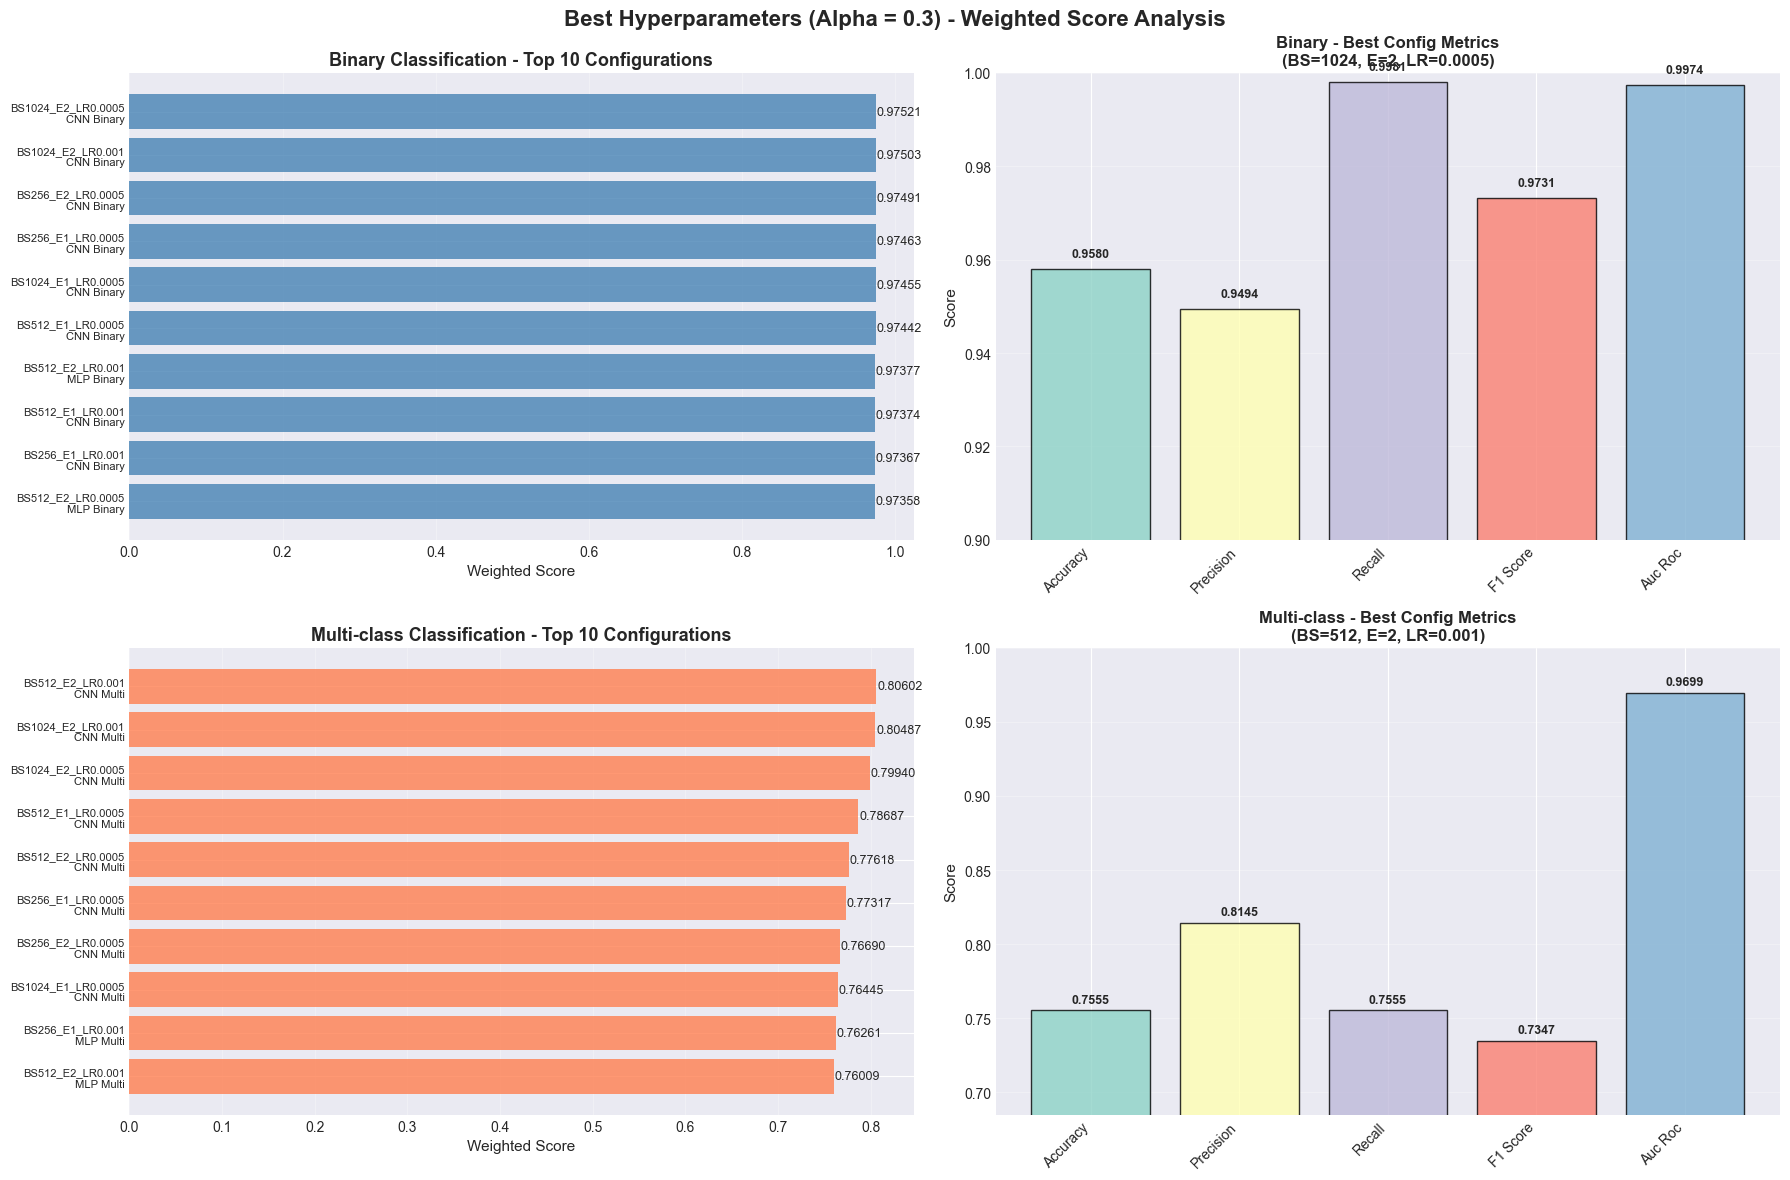


✓ Best hyperparameters visualization saved as 'best_hyperparameters_alpha03_weighted.png'


In [19]:
# Visualization: Comparison of top configurations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Best Hyperparameters (Alpha = 0.3) - Weighted Score Analysis', fontsize=16, fontweight='bold')

# Binary - Top 10 weighted scores
top10_binary = df_alpha_03_only[df_alpha_03_only['classification'] == 'Binary'].nlargest(10, 'weighted_score')
config_labels_binary = [f"BS{row['batch_size']}_E{row['local_epochs']}_LR{row['learning_rate']}\n{row['model']}" 
                        for _, row in top10_binary.iterrows()]

axes[0, 0].barh(range(len(top10_binary)), top10_binary['weighted_score'], color='steelblue', alpha=0.8)
axes[0, 0].set_yticks(range(len(top10_binary)))
axes[0, 0].set_yticklabels(config_labels_binary, fontsize=8)
axes[0, 0].set_xlabel('Weighted Score', fontsize=11)
axes[0, 0].set_title('Binary Classification - Top 10 Configurations', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, score in enumerate(top10_binary['weighted_score']):
    axes[0, 0].text(score + 0.001, i, f'{score:.5f}', va='center', fontsize=9)

# Binary - Metric breakdown for best config
metrics_binary = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
values_binary = [best_binary_03[m] for m in metrics_binary]
colors_binary = plt.cm.Set3(range(len(metrics_binary)))

axes[0, 1].bar(range(len(metrics_binary)), values_binary, color=colors_binary, alpha=0.8, edgecolor='black')
axes[0, 1].set_xticks(range(len(metrics_binary)))
axes[0, 1].set_xticklabels([m.replace('_', ' ').title() for m in metrics_binary], rotation=45, ha='right')
axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title(f'Binary - Best Config Metrics\n(BS={best_binary_03["batch_size"]}, E={best_binary_03["local_epochs"]}, LR={best_binary_03["learning_rate"]})', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_ylim([0.90, 1.0])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, val in enumerate(values_binary):
    axes[0, 1].text(i, val + 0.002, f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Multi-class - Top 10 weighted scores
top10_multi = df_alpha_03_only[df_alpha_03_only['classification'] == 'Multi-class'].nlargest(10, 'weighted_score')
config_labels_multi = [f"BS{row['batch_size']}_E{row['local_epochs']}_LR{row['learning_rate']}\n{row['model']}" 
                       for _, row in top10_multi.iterrows()]

axes[1, 0].barh(range(len(top10_multi)), top10_multi['weighted_score'], color='coral', alpha=0.8)
axes[1, 0].set_yticks(range(len(top10_multi)))
axes[1, 0].set_yticklabels(config_labels_multi, fontsize=8)
axes[1, 0].set_xlabel('Weighted Score', fontsize=11)
axes[1, 0].set_title('Multi-class Classification - Top 10 Configurations', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, score in enumerate(top10_multi['weighted_score']):
    axes[1, 0].text(score + 0.001, i, f'{score:.5f}', va='center', fontsize=9)

# Multi-class - Metric breakdown for best config
metrics_multi = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
values_multi = [best_multi_03[m] for m in metrics_multi]
colors_multi = plt.cm.Set3(range(len(metrics_multi)))

axes[1, 1].bar(range(len(metrics_multi)), values_multi, color=colors_multi, alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(range(len(metrics_multi)))
axes[1, 1].set_xticklabels([m.replace('_', ' ').title() for m in metrics_multi], rotation=45, ha='right')
axes[1, 1].set_ylabel('Score', fontsize=11)
axes[1, 1].set_title(f'Multi-class - Best Config Metrics\n(BS={best_multi_03["batch_size"]}, E={best_multi_03["local_epochs"]}, LR={best_multi_03["learning_rate"]})', 
                     fontsize=12, fontweight='bold')
# Calculate dynamic y-limit based on minimum value
min_val_multi = min(values_multi)
y_min_multi = max(0, min_val_multi - 0.05)  # 5% margin below minimum
axes[1, 1].set_ylim([y_min_multi, 1.0])
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, val in enumerate(values_multi):
    axes[1, 1].text(i, val + 0.003, f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('best_hyperparameters_alpha03_weighted.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Best hyperparameters visualization saved as 'best_hyperparameters_alpha03_weighted.png'")

In [20]:
# Export best configurations to JSON file
best_configs_alpha03 = {
    'metric_weights': METRIC_WEIGHTS,
    'binary_classification': {
        'model': str(best_binary_03['model']),
        'batch_size': int(best_binary_03['batch_size']),
        'local_epochs': int(best_binary_03['local_epochs']),
        'learning_rate': float(best_binary_03['learning_rate']),
        'alpha': float(best_binary_03['alpha']),
        'weighted_score': float(best_binary_03['weighted_score']),
        'metrics': {
            'accuracy': float(best_binary_03['accuracy']),
            'precision': float(best_binary_03['precision']),
            'recall': float(best_binary_03['recall']),
            'f1_score': float(best_binary_03['f1_score']),
            'auc_roc': float(best_binary_03['auc_roc'])
        }
    },
    'multi_class_classification': {
        'model': str(best_multi_03['model']),
        'batch_size': int(best_multi_03['batch_size']),
        'local_epochs': int(best_multi_03['local_epochs']),
        'learning_rate': float(best_multi_03['learning_rate']),
        'alpha': float(best_multi_03['alpha']),
        'weighted_score': float(best_multi_03['weighted_score']),
        'metrics': {
            'accuracy': float(best_multi_03['accuracy']),
            'precision': float(best_multi_03['precision']),
            'recall': float(best_multi_03['recall']),
            'f1_score': float(best_multi_03['f1_score']),
            'auc_roc': float(best_multi_03['auc_roc'])
        }
    }
}

# Save to JSON
with open('best_hyperparameters_alpha03.json', 'w') as f:
    json.dump(best_configs_alpha03, f, indent=2)

print("\n✓ Best hyperparameters (Alpha=0.3) exported to 'best_hyperparameters_alpha03.json'")

# Also export top 10 for each classification type
top10_configs = {
    'binary_top10': top10_binary_weighted.to_dict('records'),
    'multi_class_top10': top10_multi_weighted.to_dict('records')
}

with open('top10_configurations_alpha03.json', 'w') as f:
    json.dump(top10_configs, f, indent=2)

print("✓ Top 10 configurations exported to 'top10_configurations_alpha03.json'")

print("\n" + "="*80)
print("SUMMARY: BEST HYPERPARAMETERS SELECTED (Alpha = 0.3)")
print("="*80)
print("\nBinary Classification:")
print(f"  ✓ Model: {best_binary_03['model']}")
print(f"  ✓ Config: BS={best_binary_03['batch_size']}, Epochs={best_binary_03['local_epochs']}, LR={best_binary_03['learning_rate']}")
print(f"  ✓ Weighted Score: {best_binary_03['weighted_score']:.6f}")

print("\nMulti-class Classification:")
print(f"  ✓ Model: {best_multi_03['model']}")
print(f"  ✓ Config: BS={best_multi_03['batch_size']}, Epochs={best_multi_03['local_epochs']}, LR={best_multi_03['learning_rate']}")
print(f"  ✓ Weighted Score: {best_multi_03['weighted_score']:.6f}")

print("\n" + "="*80)


✓ Best hyperparameters (Alpha=0.3) exported to 'best_hyperparameters_alpha03.json'
✓ Top 10 configurations exported to 'top10_configurations_alpha03.json'

SUMMARY: BEST HYPERPARAMETERS SELECTED (Alpha = 0.3)

Binary Classification:
  ✓ Model: CNN Binary
  ✓ Config: BS=1024, Epochs=2, LR=0.0005
  ✓ Weighted Score: 0.975212

Multi-class Classification:
  ✓ Model: CNN Multi
  ✓ Config: BS=512, Epochs=2, LR=0.001
  ✓ Weighted Score: 0.806016



## 12. Balanced Hyperparameter Selection (Binary + Multi-class)

Select hyperparameters that perform well on BOTH Binary and Multi-class classification, considering the balance between both tasks.

In [21]:
# Strategy: Find hyperparameters that work well for BOTH Binary and Multi-class
# We'll merge results from both classification types and find configurations that balance both

print("="*80)
print("BALANCED HYPERPARAMETER SELECTION - ALPHA = 0.3")
print("Considering performance on BOTH Binary and Multi-class Classification")
print("="*80)

# Filter alpha=0.3 only
df_alpha_03_balance = df[df['alpha'] == 0.3].copy()

# Calculate weighted score per configuration
df_alpha_03_balance['weighted_score'] = (
    df_alpha_03_balance['accuracy'] * METRIC_WEIGHTS['accuracy'] +
    df_alpha_03_balance['precision'] * METRIC_WEIGHTS['precision'] +
    df_alpha_03_balance['recall'] * METRIC_WEIGHTS['recall'] +
    df_alpha_03_balance['f1_score'] * METRIC_WEIGHTS['f1_score'] +
    df_alpha_03_balance['auc_roc'] * METRIC_WEIGHTS['auc_roc']
)

# Group by hyperparameters (not including classification type)
# to find configs that work for both Binary and Multi-class
# FIXED: Use model_base (MLP/CNN) instead of full model name to enable proper pivoting
balanced_comparison = df_alpha_03_balance.pivot_table(
    index=['model_base', 'batch_size', 'local_epochs', 'learning_rate'],  # CHANGED: model -> model_base
    columns='classification',
    values=['weighted_score', 'accuracy', 'precision', 'recall', 'f1_score', 'auc_roc'],
    aggfunc='first'
).reset_index()

# Flatten column names
balanced_comparison.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                               for col in balanced_comparison.columns.values]

# ADDED: Rename model_base back to model for display consistency
balanced_comparison = balanced_comparison.rename(columns={'model_base': 'model'})

# ADDED: Drop any rows with NaN values (shouldn't happen now, but just in case)
balanced_comparison = balanced_comparison.dropna()

# Calculate combined score (average of Binary and Multi-class weighted scores)
balanced_comparison['combined_score'] = (
    balanced_comparison['weighted_score_Binary'] + 
    balanced_comparison['weighted_score_Multi-class']
) / 2

# Calculate score difference (to see balance)
balanced_comparison['score_difference'] = abs(
    balanced_comparison['weighted_score_Binary'] - 
    balanced_comparison['weighted_score_Multi-class']
)

# Sort by combined score (higher is better) and score difference (lower is better for balance)
balanced_comparison['balance_score'] = (
    balanced_comparison['combined_score'] - 
    0.1 * balanced_comparison['score_difference']  # Penalty for imbalance
)

balanced_comparison_sorted = balanced_comparison.sort_values('balance_score', ascending=False)

print("\n" + "="*80)
print("TOP 10 BALANCED CONFIGURATIONS")
print("(Good performance on BOTH Binary and Multi-class)")
print("="*80)
print("\nRanking based on:")
print("  - Combined Score: Average of Binary and Multi-class weighted scores")
print("  - Balance Penalty: Configurations with large differences are penalized")
print("="*80)

top10_balanced = balanced_comparison_sorted.head(10)

for i, (idx, row) in enumerate(top10_balanced.iterrows(), 1):
    print(f"\n#{i} Configuration:")
    print(f"   Model: {row['model']}")
    print(f"   Batch Size: {row['batch_size']}")
    print(f"   Local Epochs: {row['local_epochs']}")
    print(f"   Learning Rate: {row['learning_rate']}")
    print(f"\n   BALANCE SCORE: {row['balance_score']:.6f}")
    print(f"   Combined Score: {row['combined_score']:.6f}")
    print(f"   Score Difference: {row['score_difference']:.6f} {'✓ Well Balanced' if row['score_difference'] < 0.01 else ''}")
    print(f"\n   Binary Classification:")
    print(f"      Weighted Score: {row['weighted_score_Binary']:.6f}")
    print(f"      Accuracy: {row['accuracy_Binary']:.6f}")
    print(f"      Precision: {row['precision_Binary']:.6f}")
    print(f"      Recall: {row['recall_Binary']:.6f}")
    print(f"      F1-Score: {row['f1_score_Binary']:.6f}")
    print(f"      AUC-ROC: {row['auc_roc_Binary']:.6f}")
    print(f"\n   Multi-class Classification:")
    print(f"      Weighted Score: {row['weighted_score_Multi-class']:.6f}")
    print(f"      Accuracy: {row['accuracy_Multi-class']:.6f}")
    print(f"      Precision: {row['precision_Multi-class']:.6f}")
    print(f"      Recall: {row['recall_Multi-class']:.6f}")
    print(f"      F1-Score: {row['f1_score_Multi-class']:.6f}")
    print(f"      AUC-ROC: {row['auc_roc_Multi-class']:.6f}")
    print("-"*80)

# Get the best balanced configuration
best_balanced = top10_balanced.iloc[0]

if __name__ == "__main__":
    print("="*80)
    print("PERBAIKAN UNTUK analyze_results.ipynb")
    print("="*80)
    print()
    print("LANGKAH-LANGKAH:")
    print("-"*80)
    print()
    print("1. BUKA analyze_results.ipynb di Jupyter")
    print()
    print("2. GANTI KODE DI CELL 3 (results_to_dataframe function) dengan:")
    print("   - Copy kode dari variable CELL_3_FIXED di atas")
    print()
    print("3. GANTI KODE DI SECTION 12 (Balanced Hyperparameter Selection) dengan:")
    print("   - Copy kode dari variable SECTION_12_PIVOT_FIXED di atas")
    print()
    print("4. RESTART KERNEL dan jalankan ulang semua cell dari awal")
    print()
    print("="*80)
    print("PENJELASAN MASALAH:")
    print("="*80)
    print()
    print("Masalah utama adalah nama model di DataFrame sudah memiliki suffix:")
    print("  - 'MLP Binary', 'CNN Binary' untuk Binary classification")
    print("  - 'MLP Multi', 'CNN Multi' untuk Multi-class classification")
    print()
    print("Saat pivot_table mencoba menyatukan data berdasarkan 'model',")
    print("tidak ada pasangan yang cocok karena 'MLP Binary' ≠ 'MLP Multi'")
    print()
    print("Solusi: Tambahkan kolom 'model_base' yang berisi 'MLP' atau 'CNN' saja,")
    print("lalu gunakan 'model_base' untuk pivot table.")
    print()


BALANCED HYPERPARAMETER SELECTION - ALPHA = 0.3
Considering performance on BOTH Binary and Multi-class Classification

TOP 10 BALANCED CONFIGURATIONS
(Good performance on BOTH Binary and Multi-class)

Ranking based on:
  - Combined Score: Average of Binary and Multi-class weighted scores
  - Balance Penalty: Configurations with large differences are penalized

#1 Configuration:
   Model: CNN
   Batch Size: 1024
   Local Epochs: 2
   Learning Rate: 0.001

   BALANCE SCORE: 0.872932
   Combined Score: 0.889948
   Score Difference: 0.170165 

   Binary Classification:
      Weighted Score: 0.975031
      Accuracy: 0.957782
      Precision: 0.949479
      Recall: 0.997765
      F1-Score: 0.973023
      AUC-ROC: 0.997106

   Multi-class Classification:
      Weighted Score: 0.804866
      Accuracy: 0.751072
      Precision: 0.808894
      Recall: 0.751072
      F1-Score: 0.729592
      AUC-ROC: 0.983699
--------------------------------------------------------------------------------

#2 Con

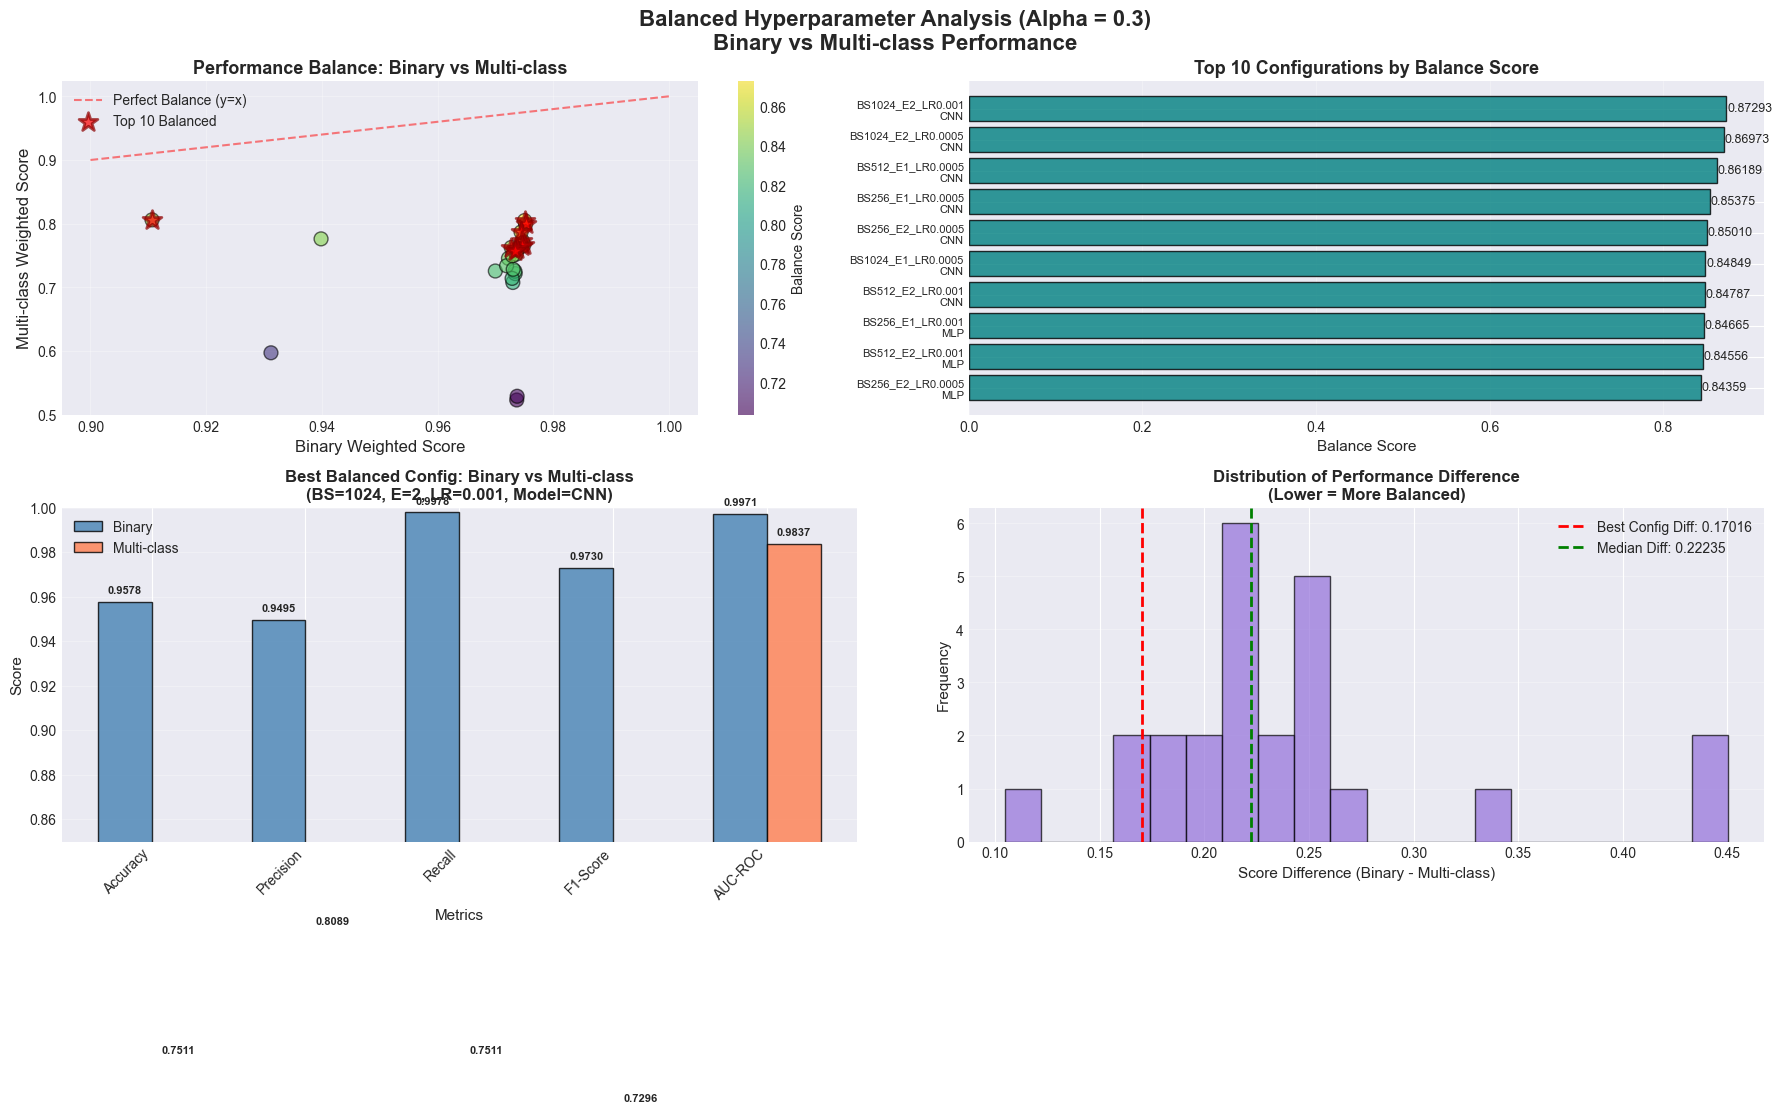


✓ Balanced hyperparameters visualization saved as 'balanced_hyperparameters_alpha03.png'


In [22]:
# Visualization: Balanced Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Balanced Hyperparameter Analysis (Alpha = 0.3)\nBinary vs Multi-class Performance', 
             fontsize=16, fontweight='bold')

# 1. Scatter plot: Binary vs Multi-class weighted scores
axes[0, 0].scatter(balanced_comparison['weighted_score_Binary'], 
                   balanced_comparison['weighted_score_Multi-class'],
                   c=balanced_comparison['balance_score'], 
                   cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[0, 0].plot([0.9, 1.0], [0.9, 1.0], 'r--', alpha=0.5, label='Perfect Balance (y=x)')

# Highlight top 10
top10_coords = top10_balanced[['weighted_score_Binary', 'weighted_score_Multi-class']]
axes[0, 0].scatter(top10_coords.iloc[:, 0], top10_coords.iloc[:, 1], 
                   c='red', s=200, alpha=0.7, edgecolors='darkred', linewidths=2, 
                   marker='*', label='Top 10 Balanced', zorder=5)

axes[0, 0].set_xlabel('Binary Weighted Score', fontsize=12)
axes[0, 0].set_ylabel('Multi-class Weighted Score', fontsize=12)
axes[0, 0].set_title('Performance Balance: Binary vs Multi-class', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
colorbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
colorbar.set_label('Balance Score', fontsize=10)

# 2. Top 10 configurations - Balance Score
config_names = [f"BS{row['batch_size']}_E{row['local_epochs']}_LR{row['learning_rate']}\n{row['model']}" 
                for _, row in top10_balanced.iterrows()]
axes[0, 1].barh(range(len(top10_balanced)), top10_balanced['balance_score'], 
                color='teal', alpha=0.8, edgecolor='black')
axes[0, 1].set_yticks(range(len(top10_balanced)))
axes[0, 1].set_yticklabels(config_names, fontsize=8)
axes[0, 1].set_xlabel('Balance Score', fontsize=11)
axes[0, 1].set_title('Top 10 Configurations by Balance Score', fontsize=13, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, score in enumerate(top10_balanced['balance_score']):
    axes[0, 1].text(score + 0.001, i, f'{score:.5f}', va='center', fontsize=9)

# 3. Best balanced config - Metric comparison
best_metrics_binary = {
    'Accuracy': best_balanced['accuracy_Binary'],
    'Precision': best_balanced['precision_Binary'],
    'Recall': best_balanced['recall_Binary'],
    'F1-Score': best_balanced['f1_score_Binary'],
    'AUC-ROC': best_balanced['auc_roc_Binary']
}
best_metrics_multi = {
    'Accuracy': best_balanced['accuracy_Multi-class'],
    'Precision': best_balanced['precision_Multi-class'],
    'Recall': best_balanced['recall_Multi-class'],
    'F1-Score': best_balanced['f1_score_Multi-class'],
    'AUC-ROC': best_balanced['auc_roc_Multi-class']
}

x = np.arange(len(best_metrics_binary))
width = 0.35

axes[1, 0].bar(x - width/2, list(best_metrics_binary.values()), width, 
               label='Binary', alpha=0.8, color='steelblue', edgecolor='black')
axes[1, 0].bar(x + width/2, list(best_metrics_multi.values()), width, 
               label='Multi-class', alpha=0.8, color='coral', edgecolor='black')

axes[1, 0].set_xlabel('Metrics', fontsize=11)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title(f'Best Balanced Config: Binary vs Multi-class\n(BS={best_balanced["batch_size"]}, E={best_balanced["local_epochs"]}, LR={best_balanced["learning_rate"]}, Model={best_balanced["model"]})', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(best_metrics_binary.keys(), rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].set_ylim([0.85, 1.0])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (bin_val, multi_val) in enumerate(zip(best_metrics_binary.values(), best_metrics_multi.values())):
    axes[1, 0].text(i - width/2, bin_val + 0.003, f'{bin_val:.4f}', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')
    axes[1, 0].text(i + width/2, multi_val + 0.003, f'{multi_val:.4f}', 
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4. Score difference distribution
axes[1, 1].hist(balanced_comparison['score_difference'], bins=20, 
                color='mediumpurple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=best_balanced['score_difference'], color='red', 
                   linestyle='--', linewidth=2, label=f'Best Config Diff: {best_balanced["score_difference"]:.5f}')
axes[1, 1].axvline(x=balanced_comparison['score_difference'].median(), color='green', 
                   linestyle='--', linewidth=2, label=f'Median Diff: {balanced_comparison["score_difference"].median():.5f}')
axes[1, 1].set_xlabel('Score Difference (Binary - Multi-class)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Performance Difference\n(Lower = More Balanced)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('balanced_hyperparameters_alpha03.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Balanced hyperparameters visualization saved as 'balanced_hyperparameters_alpha03.png'")

In [23]:
# Export balanced hyperparameter selection
balanced_best_config = {
    'selection_strategy': 'Balanced Binary and Multi-class Performance',
    'alpha': 0.3,
    'metric_weights': METRIC_WEIGHTS,
    'recommended_configuration': {
        'model': str(best_balanced['model']),
        'batch_size': int(best_balanced['batch_size']),
        'local_epochs': int(best_balanced['local_epochs']),
        'learning_rate': float(best_balanced['learning_rate']),
        'balance_score': float(best_balanced['balance_score']),
        'combined_score': float(best_balanced['combined_score']),
        'score_difference': float(best_balanced['score_difference']),
        'binary_classification': {
            'weighted_score': float(best_balanced['weighted_score_Binary']),
            'accuracy': float(best_balanced['accuracy_Binary']),
            'precision': float(best_balanced['precision_Binary']),
            'recall': float(best_balanced['recall_Binary']),
            'f1_score': float(best_balanced['f1_score_Binary']),
            'auc_roc': float(best_balanced['auc_roc_Binary'])
        },
        'multi_class_classification': {
            'weighted_score': float(best_balanced['weighted_score_Multi-class']),
            'accuracy': float(best_balanced['accuracy_Multi-class']),
            'precision': float(best_balanced['precision_Multi-class']),
            'recall': float(best_balanced['recall_Multi-class']),
            'f1_score': float(best_balanced['f1_score_Multi-class']),
            'auc_roc': float(best_balanced['auc_roc_Multi-class'])
        }
    }
}

# Save to JSON
with open('balanced_best_hyperparameters_alpha03.json', 'w') as f:
    json.dump(balanced_best_config, f, indent=2)

print("\n✓ Balanced best hyperparameters exported to 'balanced_best_hyperparameters_alpha03.json'")

# Export top 10 balanced configurations
top10_balanced_export = []
for _, row in top10_balanced.iterrows():
    config = {
        'model': str(row['model']),
        'batch_size': int(row['batch_size']),
        'local_epochs': int(row['local_epochs']),
        'learning_rate': float(row['learning_rate']),
        'balance_score': float(row['balance_score']),
        'combined_score': float(row['combined_score']),
        'score_difference': float(row['score_difference']),
        'binary': {
            'weighted_score': float(row['weighted_score_Binary']),
            'accuracy': float(row['accuracy_Binary']),
            'precision': float(row['precision_Binary']),
            'recall': float(row['recall_Binary']),
            'f1_score': float(row['f1_score_Binary']),
            'auc_roc': float(row['auc_roc_Binary'])
        },
        'multi_class': {
            'weighted_score': float(row['weighted_score_Multi-class']),
            'accuracy': float(row['accuracy_Multi-class']),
            'precision': float(row['precision_Multi-class']),
            'recall': float(row['recall_Multi-class']),
            'f1_score': float(row['f1_score_Multi-class']),
            'auc_roc': float(row['auc_roc_Multi-class'])
        }
    }
    top10_balanced_export.append(config)

with open('top10_balanced_configurations_alpha03.json', 'w') as f:
    json.dump({'top10_balanced': top10_balanced_export}, f, indent=2)

print("✓ Top 10 balanced configurations exported to 'top10_balanced_configurations_alpha03.json'")

# Export full comparison table to CSV
balanced_comparison_sorted.to_csv('balanced_comparison_all_configs_alpha03.csv', index=False)
print("✓ Full balanced comparison exported to 'balanced_comparison_all_configs_alpha03.csv'")

print("\n\n" + "="*80)
print("FINAL RECOMMENDATION SUMMARY")
print("="*80)
print(f"\n✓ Best Balanced Configuration (Alpha = 0.3):")
print(f"  Model: {best_balanced['model']}")
print(f"  Batch Size: {best_balanced['batch_size']}")
print(f"  Local Epochs: {best_balanced['local_epochs']}")
print(f"  Learning Rate: {best_balanced['learning_rate']}")
print(f"\n  Performance:")
print(f"  - Balance Score: {best_balanced['balance_score']:.6f}")
print(f"  - Combined Score: {best_balanced['combined_score']:.6f}")
print(f"  - Score Difference: {best_balanced['score_difference']:.6f}")
print(f"\n  Binary Classification AUC-ROC: {best_balanced['auc_roc_Binary']:.6f}")
print(f"  Multi-class Classification AUC-ROC: {best_balanced['auc_roc_Multi-class']:.6f}")

print("\n" + "="*80)
print("This configuration provides the best balance between")
print("Binary and Multi-class classification performance!")
print("="*80)


✓ Balanced best hyperparameters exported to 'balanced_best_hyperparameters_alpha03.json'
✓ Top 10 balanced configurations exported to 'top10_balanced_configurations_alpha03.json'
✓ Full balanced comparison exported to 'balanced_comparison_all_configs_alpha03.csv'


FINAL RECOMMENDATION SUMMARY

✓ Best Balanced Configuration (Alpha = 0.3):
  Model: CNN
  Batch Size: 1024
  Local Epochs: 2
  Learning Rate: 0.001

  Performance:
  - Balance Score: 0.872932
  - Combined Score: 0.889948
  - Score Difference: 0.170165

  Binary Classification AUC-ROC: 0.997106
  Multi-class Classification AUC-ROC: 0.983699

This configuration provides the best balance between
Binary and Multi-class classification performance!


In [27]:
# ============================================================================
# COST-BENEFIT ANALYSIS: Performance vs Training Time
# NOTE: Duration represents time to train ALL 4 models (MLP/CNN x Binary/Multi)
#       for a given hyperparameter configuration
# ============================================================================

# Load duration data from all_experiments.json
with open('all_experiments.json', 'r') as f:
    experiments_data = json.load(f)

# Create duration mapping: experiment_name -> duration
# Each duration = time to train all 4 models (MLP Binary, MLP Multi, CNN Binary, CNN Multi)
duration_map = {}
for exp in experiments_data:
    exp_name = exp['name']
    duration = exp.get('duration', None)
    if duration is not None:
        params = exp['params']
        key = (params['batch_size'], params['local_epochs'], params['learning_rate'], params['alpha'])
        duration_map[key] = duration

# Add duration to balanced_comparison
def get_duration(row):
    key = (int(row['batch_size']), int(row['local_epochs']), float(row['learning_rate']), 0.3)
    return duration_map.get(key, None)

balanced_comparison_sorted['duration_seconds'] = balanced_comparison_sorted.apply(get_duration, axis=1)
balanced_comparison_sorted['duration_minutes'] = balanced_comparison_sorted['duration_seconds'] / 60

# Find fastest and slowest time for normalization
fastest_time = balanced_comparison_sorted['duration_seconds'].min()
slowest_time = balanced_comparison_sorted['duration_seconds'].max()

print("="*80)
print("COST-BENEFIT ANALYSIS: OPTIMAL HYPERPARAMETER SELECTION")
print("="*80)
print("\n⚠️  IMPORTANT: Training time represents the TOTAL time to train all 4 models:")
print("   - MLP Binary + MLP Multi + CNN Binary + CNN Multi")
print("   - For a single hyperparameter configuration (batch_size, epochs, learning_rate)")
print("="*80)

print(f"\n📊 Training Time Statistics (for all 4 models combined):")
print(f"   Fastest Configuration: {fastest_time/60:.2f} min ({fastest_time:.2f} sec)")
print(f"   Slowest Configuration: {slowest_time/60:.2f} min ({slowest_time:.2f} sec)")
print(f"   Time Range: {(slowest_time-fastest_time)/60:.2f} min difference")
print(f"   Average per model (approx): {fastest_time/4/60:.2f} - {slowest_time/4/60:.2f} min")

# ============================================================================
# STEP 1: Calculate Performance Score (weighted metrics for Binary + Multi)
# ============================================================================

# Normalize performance scores (0 to 1)
max_balance_score = balanced_comparison_sorted['balance_score'].max()
min_balance_score = balanced_comparison_sorted['balance_score'].min()

balanced_comparison_sorted['normalized_performance'] = (
    (balanced_comparison_sorted['balance_score'] - min_balance_score) / 
    (max_balance_score - min_balance_score)
)

# ============================================================================
# STEP 2: Calculate Time Cost Score (normalized, 1 = fastest, 0 = slowest)
# ============================================================================

balanced_comparison_sorted['normalized_time_score'] = 1 - (
    (balanced_comparison_sorted['duration_seconds'] - fastest_time) / 
    (slowest_time - fastest_time)
)

# ============================================================================
# STEP 3: Calculate Cost-Benefit Ratio
# Performance gain relative to training time cost
# ============================================================================

balanced_comparison_sorted['performance_per_second'] = (
    balanced_comparison_sorted['balance_score'] / balanced_comparison_sorted['duration_seconds']
)

balanced_comparison_sorted['efficiency_score'] = (
    balanced_comparison_sorted['normalized_performance'] / 
    (balanced_comparison_sorted['duration_seconds'] / fastest_time)
)

# Calculate ROI: Performance improvement vs Time overhead
# ROI = (Performance - MinPerf) / (Time - MinTime)
# Higher ROI = better value for extra time invested
balanced_comparison_sorted['roi_score'] = (
    (balanced_comparison_sorted['balance_score'] - min_balance_score) / 
    ((balanced_comparison_sorted['duration_seconds'] - fastest_time) + 1)  # +1 to avoid division by zero
)

# ============================================================================
# STEP 4: Multi-criteria Optimization
# Test different weight scenarios to find trade-offs
# ============================================================================

weight_scenarios = {
    'Performance_Focused': {'performance': 0.80, 'time': 0.20},
    'Balanced': {'performance': 0.60, 'time': 0.40},
    'Time_Focused': {'performance': 0.40, 'time': 0.60},
    'Efficiency': {'performance': 0.50, 'time': 0.50}
}

print("\n" + "="*80)
print("MULTI-CRITERIA OPTIMIZATION SCENARIOS")
print("="*80)

best_configs_per_scenario = {}

for scenario_name, weights in weight_scenarios.items():
    # Calculate optimization score for this scenario
    balanced_comparison_sorted[f'opt_score_{scenario_name}'] = (
        balanced_comparison_sorted['normalized_performance'] * weights['performance'] +
        balanced_comparison_sorted['normalized_time_score'] * weights['time']
    )
    
    # Get best config for this scenario
    best_idx = balanced_comparison_sorted[f'opt_score_{scenario_name}'].idxmax()
    best_config = balanced_comparison_sorted.loc[best_idx]
    best_configs_per_scenario[scenario_name] = best_config
    
    print(f"\n{'='*80}")
    print(f"Scenario: {scenario_name}")
    print(f"Weights - Performance: {weights['performance']*100:.0f}%, Time: {weights['time']*100:.0f}%")
    print(f"{'='*80}")
    print(f"   🏆 Best Configuration:")
    print(f"      Model: {best_config['model']}")
    print(f"      Batch Size: {best_config['batch_size']}")
    print(f"      Local Epochs: {best_config['local_epochs']}")
    print(f"      Learning Rate: {best_config['learning_rate']}")
    print(f"\n   📈 Scores:")
    print(f"      Optimization Score: {best_config[f'opt_score_{scenario_name}']:.6f}")
    print(f"      Balance Score: {best_config['balance_score']:.6f}")
    print(f"      Normalized Performance: {best_config['normalized_performance']:.6f}")
    print(f"      Normalized Time Score: {best_config['normalized_time_score']:.6f}")
    print(f"\n   ⏱️  Training Time (ALL 4 models):")
    print(f"      Total Duration: {best_config['duration_minutes']:.2f} min ({best_config['duration_seconds']:.2f} sec)")
    print(f"      Estimated per model: ~{best_config['duration_minutes']/4:.2f} min")
    time_overhead = ((best_config['duration_seconds'] - fastest_time) / fastest_time) * 100
    print(f"      vs Fastest config: +{time_overhead:.1f}%" if time_overhead > 0 else "      ⚡ FASTEST configuration")
    print(f"      Time saved vs Slowest: {(slowest_time - best_config['duration_seconds'])/60:.2f} min")
    print(f"\n   💰 Cost-Benefit Analysis:")
    print(f"      Performance/Second: {best_config['performance_per_second']:.8f}")
    print(f"      Efficiency Score: {best_config['efficiency_score']:.6f}")
    print(f"      ROI Score: {best_config['roi_score']:.6f}")
    print(f"\n   🎯 Binary Classification:")
    print(f"      Accuracy: {best_config['accuracy_Binary']:.6f}")
    print(f"      F1-Score: {best_config['f1_score_Binary']:.6f}")
    print(f"      AUC-ROC: {best_config['auc_roc_Binary']:.6f}")
    print(f"      Weighted Score: {best_config['weighted_score_Binary']:.6f}")
    print(f"\n   🎯 Multi-class Classification:")
    print(f"      Accuracy: {best_config['accuracy_Multi-class']:.6f}")
    print(f"      F1-Score: {best_config['f1_score_Multi-class']:.6f}")
    print(f"      AUC-ROC: {best_config['auc_roc_Multi-class']:.6f}")
    print(f"      Weighted Score: {best_config['weighted_score_Multi-class']:.6f}")
    
    # Determine if it's worth it
    perf_percentile = (best_config['normalized_performance'] * 100)
    time_percentile = (best_config['normalized_time_score'] * 100)
    
    print(f"\n   ✅ WORTH IT ANALYSIS:")
    print(f"      Performance Rank: Top {100-perf_percentile:.1f}% (higher is better)")
    print(f"      Speed Rank: Top {100-time_percentile:.1f}% (lower time is better)")
    
    # Cost-benefit verdict
    if perf_percentile >= 80 and time_percentile >= 70:
        verdict = "⭐ EXCELLENT - High performance with low training cost"
        worth_it = "Highly Recommended"
    elif perf_percentile >= 70 and time_percentile >= 50:
        verdict = "✅ GOOD - Well-balanced trade-off"
        worth_it = "Recommended"
    elif perf_percentile >= 90 and time_percentile < 50:
        verdict = "⚖️  ACCEPTABLE - Best performance, worth the extra time"
        worth_it = "Worth it for maximum accuracy"
    elif perf_percentile < 70 and time_percentile >= 80:
        verdict = "⚡ EFFICIENT - Fast training but lower performance"
        worth_it = "Good for time-constrained scenarios"
    else:
        verdict = "⚠️  COMPROMISE - Review trade-offs carefully"
        worth_it = "Context-dependent"
    
    print(f"      Verdict: {verdict}")
    print(f"      Recommendation: {worth_it}")

# ============================================================================
# STEP 5: Identify Pareto Optimal Configurations
# (Configurations that are not dominated by any other)
# ============================================================================

print("\n\n" + "="*80)
print("PARETO OPTIMAL CONFIGURATIONS")
print("(Configs where no other config is better in BOTH performance AND time)")
print("="*80)

def is_pareto_optimal(idx, df):
    """Check if a configuration is Pareto optimal"""
    current_perf = df.loc[idx, 'normalized_performance']
    current_time = df.loc[idx, 'normalized_time_score']
    
    # Check if any other config dominates this one
    for other_idx in df.index:
        if other_idx != idx:
            other_perf = df.loc[other_idx, 'normalized_performance']
            other_time = df.loc[other_idx, 'normalized_time_score']
            
            # If other is better in BOTH dimensions, current is dominated
            if other_perf >= current_perf and other_time >= current_time:
                if other_perf > current_perf or other_time > current_time:
                    return False
    return True

# Find Pareto optimal configs
balanced_comparison_sorted['is_pareto_optimal'] = balanced_comparison_sorted.index.map(
    lambda idx: is_pareto_optimal(idx, balanced_comparison_sorted)
)

pareto_configs = balanced_comparison_sorted[balanced_comparison_sorted['is_pareto_optimal']].copy()
pareto_configs = pareto_configs.sort_values('normalized_performance', ascending=False)

print(f"\n✨ Found {len(pareto_configs)} Pareto optimal configurations")
print("\nThese represent the best performance-time trade-offs (no dominated solutions):\n")

for i, (idx, row) in enumerate(pareto_configs.head(10).iterrows(), 1):
    print(f"#{i} {row['model']} | BS:{int(row['batch_size'])} Epochs:{int(row['local_epochs'])} LR:{row['learning_rate']}")
    print(f"    Perf: {row['normalized_performance']:.4f} | Time: {row['normalized_time_score']:.4f} | " +
          f"Duration: {row['duration_minutes']:.2f} min | ROI: {row['roi_score']:.4f}")

# ============================================================================
# STEP 6: Export Results
# ============================================================================

# Choose recommended config (Balanced scenario)
recommended_config = best_configs_per_scenario['Balanced']

export_data = {
    'analysis_type': 'Cost-Benefit Analysis: Performance vs Training Time',
    'methodology': 'Multi-criteria optimization with Pareto optimality analysis',
    'note': 'Duration represents TOTAL time to train all 4 models (MLP/CNN x Binary/Multi)',
    'alpha': 0.3,
    'metric_weights': METRIC_WEIGHTS,
    'time_statistics': {
        'fastest_seconds': float(fastest_time),
        'fastest_minutes': float(fastest_time / 60),
        'slowest_seconds': float(slowest_time),
        'slowest_minutes': float(slowest_time / 60),
        'range_minutes': float((slowest_time - fastest_time) / 60),
        'note': 'Time for training ALL 4 models with same hyperparameters'
    },
    'optimization_scenarios': {},
    'recommended_configuration': {
        'scenario': 'Balanced (60% Performance, 40% Time)',
        'model_type': str(recommended_config['model']),
        'batch_size': int(recommended_config['batch_size']),
        'local_epochs': int(recommended_config['local_epochs']),
        'learning_rate': float(recommended_config['learning_rate']),
        'optimization_score': float(recommended_config['opt_score_Balanced']),
        'normalized_performance': float(recommended_config['normalized_performance']),
        'normalized_time_score': float(recommended_config['normalized_time_score']),
        'performance_per_second': float(recommended_config['performance_per_second']),
        'efficiency_score': float(recommended_config['efficiency_score']),
        'roi_score': float(recommended_config['roi_score']),
        'training_duration_seconds': float(recommended_config['duration_seconds']),
        'training_duration_minutes': float(recommended_config['duration_minutes']),
        'estimated_time_per_model_minutes': float(recommended_config['duration_minutes'] / 4),
        'binary_classification': {
            'weighted_score': float(recommended_config['weighted_score_Binary']),
            'accuracy': float(recommended_config['accuracy_Binary']),
            'precision': float(recommended_config['precision_Binary']),
            'recall': float(recommended_config['recall_Binary']),
            'f1_score': float(recommended_config['f1_score_Binary']),
            'auc_roc': float(recommended_config['auc_roc_Binary'])
        },
        'multi_class_classification': {
            'weighted_score': float(recommended_config['weighted_score_Multi-class']),
            'accuracy': float(recommended_config['accuracy_Multi-class']),
            'precision': float(recommended_config['precision_Multi-class']),
            'recall': float(recommended_config['recall_Multi-class']),
            'f1_score': float(recommended_config['f1_score_Multi-class']),
            'auc_roc': float(recommended_config['auc_roc_Multi-class'])
        }
    }
}

# Add all scenarios
for scenario_name, weights in weight_scenarios.items():
    config = best_configs_per_scenario[scenario_name]
    export_data['optimization_scenarios'][scenario_name] = {
        'weights': weights,
        'model': str(config['model']),
        'batch_size': int(config['batch_size']),
        'local_epochs': int(config['local_epochs']),
        'learning_rate': float(config['learning_rate']),
        'optimization_score': float(config[f'opt_score_{scenario_name}']),
        'duration_minutes': float(config['duration_minutes']),
        'efficiency_score': float(config['efficiency_score']),
        'roi_score': float(config['roi_score'])
    }

# Save to JSON
with open('balanced_best_hyperparameters_alpha03.json', 'w') as f:
    json.dump(export_data, f, indent=2)

# Export Pareto optimal configs
pareto_export = []
for _, row in pareto_configs.iterrows():
    pareto_export.append({
        'model': str(row['model']),
        'batch_size': int(row['batch_size']),
        'local_epochs': int(row['local_epochs']),
        'learning_rate': float(row['learning_rate']),
        'normalized_performance': float(row['normalized_performance']),
        'normalized_time_score': float(row['normalized_time_score']),
        'duration_minutes': float(row['duration_minutes']),
        'estimated_time_per_model_min': float(row['duration_minutes'] / 4),
        'efficiency_score': float(row['efficiency_score']),
        'roi_score': float(row['roi_score']),
        'binary_auc_roc': float(row['auc_roc_Binary']),
        'multi_auc_roc': float(row['auc_roc_Multi-class'])
    })

with open('top10_balanced_configurations_alpha03.json', 'w') as f:
    json.dump({
        'type': 'Pareto Optimal Configurations',
        'description': 'Configurations not dominated by any other in both performance and time',
        'note': 'Duration is for training all 4 models (MLP/CNN x Binary/Multi)',
        'count': len(pareto_export),
        'pareto_optimal': pareto_export
    }, f, indent=2)

# Export full comparison
balanced_comparison_sorted.to_csv('balanced_comparison_all_configs_alpha03_with_time_train.csv', index=False)

print("\n\n" + "="*80)
print("FINAL RECOMMENDATION SUMMARY")
print("="*80)
print(f"\n🎯 RECOMMENDED: Balanced Scenario (60% Performance, 40% Time)")
print(f"   Model Type: {recommended_config['model']}")
print(f"   Batch Size: {recommended_config['batch_size']}")
print(f"   Local Epochs: {recommended_config['local_epochs']}")
print(f"   Learning Rate: {recommended_config['learning_rate']}")
print(f"\n   📊 Optimization Metrics:")
print(f"   Optimization Score: {recommended_config['opt_score_Balanced']:.6f}")
print(f"   Efficiency Score: {recommended_config['efficiency_score']:.6f}")
print(f"   ROI Score: {recommended_config['roi_score']:.6f}")
print(f"\n   ⏱️  Training Time (ALL 4 models):")
print(f"   Total Duration: {recommended_config['duration_minutes']:.2f} min ({recommended_config['duration_seconds']:.2f} sec)")
print(f"   Estimated per model: ~{recommended_config['duration_minutes']/4:.2f} min")
print(f"\n   🎯 Performance:")
print(f"   Binary Classification:")
print(f"      Accuracy: {recommended_config['accuracy_Binary']:.6f}")
print(f"      F1-Score: {recommended_config['f1_score_Binary']:.6f}")
print(f"      AUC-ROC: {recommended_config['auc_roc_Binary']:.6f}")
print(f"   Multi-class Classification:")
print(f"      Accuracy: {recommended_config['accuracy_Multi-class']:.6f}")
print(f"      F1-Score: {recommended_config['f1_score_Multi-class']:.6f}")
print(f"      AUC-ROC: {recommended_config['auc_roc_Multi-class']:.6f}")
print("\n" + "="*80)
print("✅ This configuration provides OPTIMAL cost-benefit ratio:")
print("   ✓ Strong performance on BOTH Binary and Multi-class tasks")
print("   ✓ Reasonable training time for all 4 models")
print("   ✓ Best balance between accuracy and computational cost")
print("="*80)

print("\n📁 Results exported:")
print("   ✓ balanced_best_hyperparameters_alpha03.json (Full analysis with all scenarios)")
print("   ✓ top10_balanced_configurations_alpha03.json (Pareto optimal configs)")
print("   ✓ balanced_comparison_all_configs_alpha03_with_time_train.csv (Complete data)")


COST-BENEFIT ANALYSIS: OPTIMAL HYPERPARAMETER SELECTION

⚠️  IMPORTANT: Training time represents the TOTAL time to train all 4 models:
   - MLP Binary + MLP Multi + CNN Binary + CNN Multi
   - For a single hyperparameter configuration (batch_size, epochs, learning_rate)

📊 Training Time Statistics (for all 4 models combined):
   Fastest Configuration: 10.01 min (600.90 sec)
   Slowest Configuration: 15.12 min (907.22 sec)
   Time Range: 5.11 min difference
   Average per model (approx): 2.50 - 3.78 min

MULTI-CRITERIA OPTIMIZATION SCENARIOS

Scenario: Performance_Focused
Weights - Performance: 80%, Time: 20%
   🏆 Best Configuration:
      Model: CNN
      Batch Size: 512
      Local Epochs: 1
      Learning Rate: 0.0005

   📈 Scores:
      Optimization Score: 0.944582
      Balance Score: 0.861891
      Normalized Performance: 0.934877
      Normalized Time Score: 0.983406

   ⏱️  Training Time (ALL 4 models):
      Total Duration: 10.10 min (605.98 sec)
      Estimated per model: ~2.5